# Figures

## Setup

### Import libraries


In [2]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import ticker
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Patch
from statsmodels.formula.api import ols

from functions.data_etl.file_io import read_gdf_from_csv
from functions.data_etl.geocoding import get_continent_from_country
from functions.figures.figures import (
    calculate_pp_increased_ws_share,
    calculate_total_data_center_capacity_at_risk,
    calculate_water_use_by_basin,
    filter_by_country,
    make_capacity_at_risk_boxplot,
    plot_exacerbate_tip_water_scarcity_barchart,
    plot_months_ws_at_extraction_sites,
    plot_relative_increase_ws_map,
    plot_water_use_map,
)
from functions.project_settings import (
    GLOBAL_WARMING_SCENARIOS,
    GLOBAL_WARMING_SCENARIOS_FUTURE,
    WGS84_CRS,
)


## Setting input and output paths


In [4]:
# Input paths
INPUTS_DIR = Path("data/inputs/4_figures/")
RESULTS_DIR = Path("data/outputs/")
COUNTRIES_PATH = Path("data/inputs/common/country_boundaries/ne_110m_admin_0_countries.shp")

# Output paths
FIGURES_DIR = Path("data/outputs/figures")

## Import data


In [5]:
# Read in the country boundaries
country_boundaries = gpd.read_file(COUNTRIES_PATH)

water_scarcity_summary = {
    scenario: read_gdf_from_csv(f"{RESULTS_DIR}/3_water_scarcity/water_scarcity_summary_{scenario}.csv")
    for scenario in GLOBAL_WARMING_SCENARIOS
}

# Filter the dataframes to only include data centers
water_scarcity_summary_dc = {key: val[val["type"] == "data_center"] for key, val in water_scarcity_summary.items()}

# Filter the dataframes to only include power plants
water_scarcity_summary_pp = {key: val[val["type"] != "data_center"] for key, val in water_scarcity_summary.items()}

# Import power plant data
power_plants = read_gdf_from_csv(RESULTS_DIR / "2_energy_and_water_use/power_plants_water_use_baseline.csv")

# Import data center data without scenarios
data_centers = read_gdf_from_csv(RESULTS_DIR / "2_energy_and_water_use/data_centers_no_scenarios.csv")

# Read in the data center electricity and water use data
data_center_energy_water_use = read_gdf_from_csv(
    RESULTS_DIR / "2_energy_and_water_use/data_centers_total_water_use.csv"
)

# Import vulnerability data
vulnerability_summary = read_gdf_from_csv(RESULTS_DIR / "3_water_scarcity/water_scarcity_summary_all.csv")

# Filter the dataframe to only include data centers
vulnerability_summary_dc = vulnerability_summary[vulnerability_summary["type"] == "data_center"]

# Filter the dataframe to only include power plants
vulnerability_summary_pp = vulnerability_summary[vulnerability_summary["type"] != "data_center"]

In [ ]:
hist = water_scarcity_summary_dc['hist']
one_p_five = water_scarcity_summary_dc['1_5C']
two_p_o = water_scarcity_summary_dc['2_0C']
three_p_two = water_scarcity_summary_dc['3_2C']

In [28]:
hist_pp = water_scarcity_summary_pp['hist']
one_p_five = water_scarcity_summary_pp['1_5C']
two_p_o = water_scarcity_summary_pp['2_0C']
three_p_two = water_scarcity_summary_pp['3_2C']

In [30]:
# For operational data centers with WS_region true, find the countries they are located in and the percentage of data centers in those countries
operational_data_centers_region_countries = gpd.sjoin(
    three_p_two, country_boundaries, how="left"
)

operational_data_centers_ws_region_countries = operational_data_centers_region_countries[
    (operational_data_centers_region_countries["WS_region"])
]

country_counts_ws = operational_data_centers_ws_region_countries["SOVEREIGNT"].value_counts()
total_ws_operational_data_centers = len(operational_data_centers_ws_region_countries)
country_ws_percentage = (country_counts_ws / total_ws_operational_data_centers) * 100   

country_count = operational_data_centers_region_countries["SOVEREIGNT"].value_counts()
country_percentage = (country_counts_ws / country_count) * 100

# Average months_WS per country
average_months_ws = operational_data_centers_ws_region_countries.groupby("SOVEREIGNT")["months_WSI"].mean()

# Create dataframe with country, percentage, average months_ws, count of data centers
country_summary_three_p_two = pd.DataFrame({
    "percentage_data_centers_ws": country_ws_percentage.round(1),
    "average_months_ws": average_months_ws.round(1),
    "data_center_count_ws": country_counts_ws,
    "data_centers_total": country_count,
    "percentage_data_centers": country_percentage.round(1)
})

print(country_summary_three_p_two[["average_months_ws"]].mean())

country_summary_three_p_two


average_months_ws    3.501205
dtype: float64


percentage_data_centers_ws  average_months_ws  \
SOVEREIGNT                                                  
Algeria                            0.6                4.8   
Angola                             0.0                3.5   
Argentina                          1.0                4.2   
Armenia                            0.0                1.0   
Australia                          1.2                3.4   
...                                ...                ...   
Uruguay                            NaN                NaN   
Uzbekistan                         0.2                4.8   
Venezuela                          0.2                2.5   
Vietnam                            0.5                1.9   
eSwatini                           0.0                3.0   

            data_center_count_ws  data_centers_total  percentage_data_centers  
SOVEREIGNT                                                                     
Algeria                     46.0                  57                     80.7  
Angola                       2.0                  14                     14.3  
Argentina                   75.0                 230                     32.6  
Armenia                      2.0                   8                     25.0  
Australia                   96.0                 419                     22.9  
...                          ...                 ...                      ...  
Uruguay                      NaN                  72                      NaN  
Uzbekistan                  14.0                  14                    100.0  
Venezuela                   12.0                  37                     32.4  
Vietnam                     37.0                 183                     20.2  
eSwatini                     1.0                   1                    100.0  

[118 rows x 5 columns]

## Main figures


### Boxplots and bar chart of data center water withdrawal

In [4]:
# Load summary statistics
summary = pd.read_csv(RESULTS_DIR / "2_energy_and_water_use/data_centers_water_electricity_use_summary.csv")

In [ ]:
# Create subsets of the data
only_operational_true = summary[summary["only_operational"]]
only_operational_false = summary[~summary["only_operational"]]

# Find the baseline scenario values
baseline_all_scenarios_operational = only_operational_true.query(
    'cooling_tech_scenario == "most_common" and tech_performance == "medium" and power_scenario == "avg"'
)

baseline_all_scenarios_planned = only_operational_false.query(
    'cooling_tech_scenario == "most_common" and tech_performance == "medium" and power_scenario == "avg"'
)


In [6]:
# Replace the total values with the marginal values when only_operational is false
summary = summary.copy()
summary["total_water_use_m3"] = np.where(
    summary["only_operational"], summary["total_water_use_m3"], summary["marginal_total_water_increase_m3"]
)
summary["indirect_water_use_m3"] = np.where(
    summary["only_operational"], summary["indirect_water_use_m3"], summary["marginal_indirect_water_increase_m3"]
)
summary["direct_water_use_m3"] = np.where(
    summary["only_operational"], summary["direct_water_use_m3"], summary["marginal_direct_water_increase_m3"]
)

# Melt the dataframe to have a long format for seaborn
melted_df = summary.melt(
    id_vars=["only_operational"],
    value_vars=["direct_water_use_m3", "indirect_water_use_m3"],
    var_name="Water Use Type",
    value_name="Water Use (billion m3)",
)

# Map the 'Water Use Type' column to more descriptive labels
melted_df["Water Use Type"] = melted_df["Water Use Type"].map(
    {"direct_water_use_m3": "Direct", "indirect_water_use_m3": "Indirect"}
)

# Map the 'only_operational' column to more descriptive labels
melted_df["operational_status"] = melted_df["only_operational"].map({True: "operational", False: "Planned"})

# Set the order of the categories
melted_df["operational_status"] = pd.Categorical(
    melted_df["operational_status"], categories=["operational", "Planned"], ordered=True
)
melted_df["Water Consumption Type"] = pd.Categorical(
    melted_df["Water Use Type"], categories=["Direct", "Indirect"], ordered=True
)

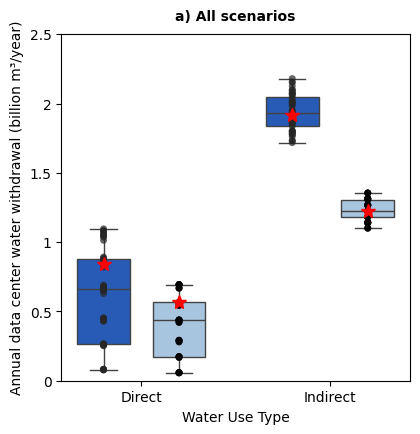

In [7]:
# Create a boxplot of water use

fig, ax = plt.subplots(figsize=(4.5, 4.5))
sns.boxplot(
    x="Water Use Type",
    y="Water Use (billion m3)",
    hue="operational_status",
    data=melted_df,
    palette=["#1155cc", "#9fc5e8"],
    order=["Direct", "Indirect"],
    hue_order=["operational", "Planned"],
    gap=0.3,
    ax=ax,
    legend=False,
)
sns.stripplot(
    x="Water Use Type",
    y="Water Use (billion m3)",
    hue="operational_status",
    data=melted_df,
    palette="dark:black",
    alpha=0.7,
    jitter=False,
    dodge=True,
    order=["Direct", "Indirect"],
    hue_order=["operational", "Planned"],
    legend=False,
    ax=ax,
)

# Plot the baseline scenario values in red stars
ax.plot(
    [-0.2],
    baseline_all_scenarios_operational["direct_water_use_m3"],
    "*",
    color="red",
    label="Baseline",
    markersize=10,
    zorder=5,
)
ax.plot(
    [0.2],
    baseline_all_scenarios_planned["marginal_direct_water_increase_m3"],
    "*",
    color="red",
    markersize=10,
    zorder=5,
)
ax.plot([0.8], baseline_all_scenarios_operational["indirect_water_use_m3"], "*", color="red", markersize=10, zorder=5)
ax.plot(
    [1.2],
    baseline_all_scenarios_planned["marginal_indirect_water_increase_m3"],
    "*",
    color="red",
    markersize=10,
    zorder=5,
)

ax.set_ylabel("Annual data center water withdrawal (billion m³/year)")
ax.set_ylim(0, 2.5e9)
ax.set_yticks([0, 0.5e9, 1e9, 1.5e9, 2e9, 2.5e9])
ax.set_yticklabels(["0", "0.5", "1", "1.5", "2", "2.5"])
ax.set_title("a) All scenarios", fontsize=10, pad=10, fontweight="bold")


fig.savefig(FIGURES_DIR / "water_use_boxplot.png", bbox_inches="tight", dpi=300)

### Bar chart of water use across scenarios


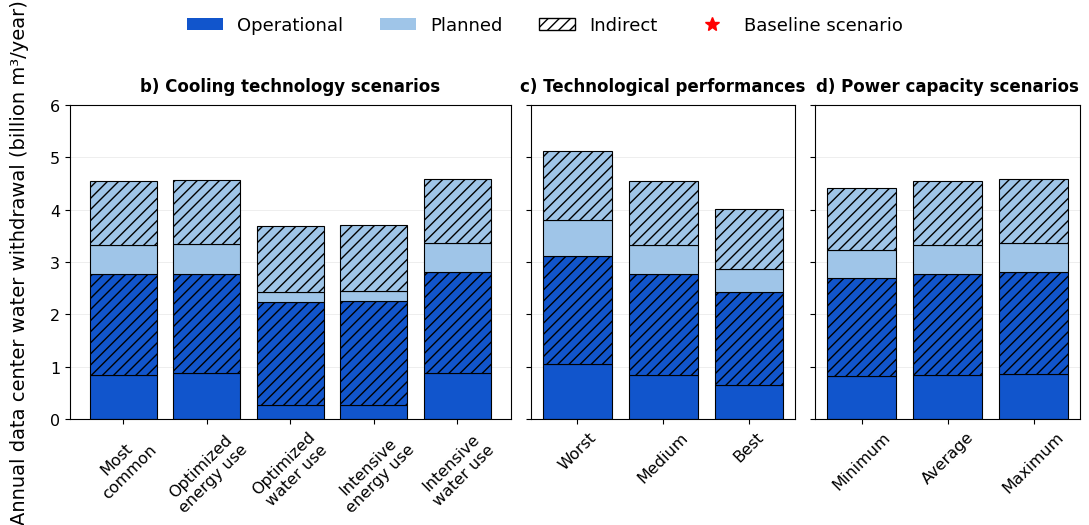

In [8]:
# Create a combined figure with three panels with widths proportional to number of bars (5:3:3)

fig = plt.figure(figsize=(11, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[5, 3, 3])
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# Define colors and hatching patterns (consistent across all panels)
colors = ["#1155cc", "#1155cc", "#9fc5e8", "#9fc5e8"]
hatches = ["", "///", "", "///"]  # Stripes for indirect
labels = ["Direct Operational", "Indirect Operational", "Direct Planned", "Indirect Planned"]


def create_panel(ax, bar_data, x_labels, title_text):
    """Helper function to create each panel"""
    x = range(len(bar_data.index))
    bottom = [0] * len(x)

    for i, column in enumerate(bar_data.columns):
        bars = ax.bar(
            x,
            bar_data[column],
            bottom=bottom,
            color=colors[i],
            hatch=hatches[i],
            label=labels[i] if ax == axes[0] else "",  # Only add labels to first panel for legend
            width=0.8,
            edgecolor="black",
            linewidth=0.8,
        )
        # Update bottom for stacking
        bottom = [b + v for b, v in zip(bottom, bar_data[column])]

    # Set labels and formatting
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha="center", fontsize=11.5)
    ax.set_title(title_text, fontsize=12, pad=10, fontweight="bold")

    # Set y-axis limits and ticks
    ax.set_ylim(0, 6e9)
    ax.set_yticks([0, 1e9, 2e9, 3e9, 4e9, 5e9, 6e9])
    ax.set_yticklabels(["0", "1", "2", "3", "4", "5", "6"], fontsize=11.5)

    # Add horizontal grid lines
    ax.grid(True, axis="y", alpha=0.3, linestyle="-", linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)


# Panel 1: Cooling Technology Scenario
# Filter on power scenario avg and tech performance medium
summary_baseline = summary[(summary["tech_performance"] == "medium") & (summary["power_scenario"] == "avg")]

# Define the mapping for scenario labels
scenario_labels = {
    "most_common": "Most\ncommon",
    "optimized_energy_use": "Optimized\nenergy use",
    "optimized_water_use": "Optimized\nwater use",
    "intensive_energy_use": "Intensive\nenergy use",
    "intensive_water_use": "Intensive\nwater use",
}

# Define the order starting with most_common
scenario_order = [
    "most_common",
    "optimized_energy_use",
    "optimized_water_use",
    "intensive_energy_use",
    "intensive_water_use",
]

# Create a DataFrame for the bar chart
bar_data_cooling = pd.DataFrame(
    {
        "Cooling Technology Scenario": summary_baseline["cooling_tech_scenario"].unique(),
        "Direct Operational": summary_baseline.query("only_operational")["direct_water_use_m3"].values,
        "Indirect Operational": summary_baseline.query("only_operational")["indirect_water_use_m3"].values,
        "Direct Planned": summary_baseline.query("~only_operational")["marginal_direct_water_increase_m3"].values,
        "Indirect Planned": summary_baseline.query("~only_operational")["marginal_indirect_water_increase_m3"].values,
    }
)
bar_data_cooling.set_index("Cooling Technology Scenario", inplace=True)
bar_data_cooling = bar_data_cooling.reindex(scenario_order)

create_panel(
    axes[0],
    bar_data_cooling,
    [scenario_labels[scenario] for scenario in scenario_order],
    "b) Cooling technology scenarios",
)

# Panel 2: Technological Performance
# Filter on cooling_tech_scenario most_common and power scenario avg
summary_tech = summary[(summary["cooling_tech_scenario"] == "most_common") & (summary["power_scenario"] == "avg")]

# Define the mapping for tech performance labels
tech_labels = {"worst": "Worst", "medium": "Medium", "best": "Best"}

# Define the order
tech_order = ["worst", "medium", "best"]

# Create a DataFrame for the bar chart
bar_data_tech = pd.DataFrame(
    {
        "Tech Performance": summary_tech["tech_performance"].unique(),
        "Direct Operational": summary_tech.query("only_operational")["direct_water_use_m3"].values,
        "Indirect Operational": summary_tech.query("only_operational")["indirect_water_use_m3"].values,
        "Direct Planned": summary_tech.query("~only_operational")["marginal_direct_water_increase_m3"].values,
        "Indirect Planned": summary_tech.query("~only_operational")["marginal_indirect_water_increase_m3"].values,
    }
)
bar_data_tech.set_index("Tech Performance", inplace=True)
bar_data_tech = bar_data_tech.reindex(tech_order)

create_panel(
    axes[1],
    bar_data_tech,
    [tech_labels[tech] for tech in tech_order],
    "c) Technological performances",
)

# Hide the y-tick labels for the second panel
axes[1].set_yticklabels([])

# Panel 3: Power Scenario
# Filter on cooling_tech_scenario most_common and tech_performance medium
summary_power = summary[(summary["cooling_tech_scenario"] == "most_common") & (summary["tech_performance"] == "medium")]

# Define the mapping for power scenario labels
power_labels = {"min": "Minimum", "avg": "Average", "max": "Maximum"}

# Define the order
power_order = ["min", "avg", "max"]

# Create a DataFrame for the bar chart
bar_data_power = pd.DataFrame(
    {
        "Power Scenario": summary_power["power_scenario"].unique(),
        "Direct Operational": summary_power.query("only_operational")["direct_water_use_m3"].values,
        "Indirect Operational": summary_power.query("only_operational")["indirect_water_use_m3"].values,
        "Direct Planned": summary_power.query("~only_operational")["marginal_direct_water_increase_m3"].values,
        "Indirect Planned": summary_power.query("~only_operational")["marginal_indirect_water_increase_m3"].values,
    }
)
bar_data_power.set_index("Power Scenario", inplace=True)
bar_data_power = bar_data_power.reindex(power_order)

create_panel(axes[2], bar_data_power, [power_labels[power] for power in power_order], "d) Power capacity scenarios")

# Hide y-ticks for third panel
axes[2].set_yticklabels([])

# Add y-label to all panels at the same lower position
for i, ax in enumerate(axes):
    if i == 0:  # Only show y-label text on the first panel
        ax.set_ylabel("Annual data center water withdrawal (billion m³/year)", fontsize=14, labelpad=15)
    else:  # For other panels, set invisible y-label to maintain consistent positioning
        ax.set_ylabel("", fontsize=14, labelpad=15)

# Create custom legend
legend_elements = [
    Patch(facecolor="#1155cc", label="Operational"),
    Patch(facecolor="#9fc5e8", label="Planned"),
    Patch(facecolor="white", hatch="///", edgecolor="black", label="Indirect"),
    # Add red star for baseline
    Line2D([], [], marker="*", color="red", label="Baseline scenario", markersize=10, linestyle="None"),
]

# Create a shared legend at the top
fig.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 1.06), ncol=4, fontsize=13, frameon=False)

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Make room for the legend

fig.savefig(FIGURES_DIR / "water_use_stacked_bar_chart_across_variables.png", bbox_inches="tight", dpi=300)

### Water scarcity maps at extraction sites

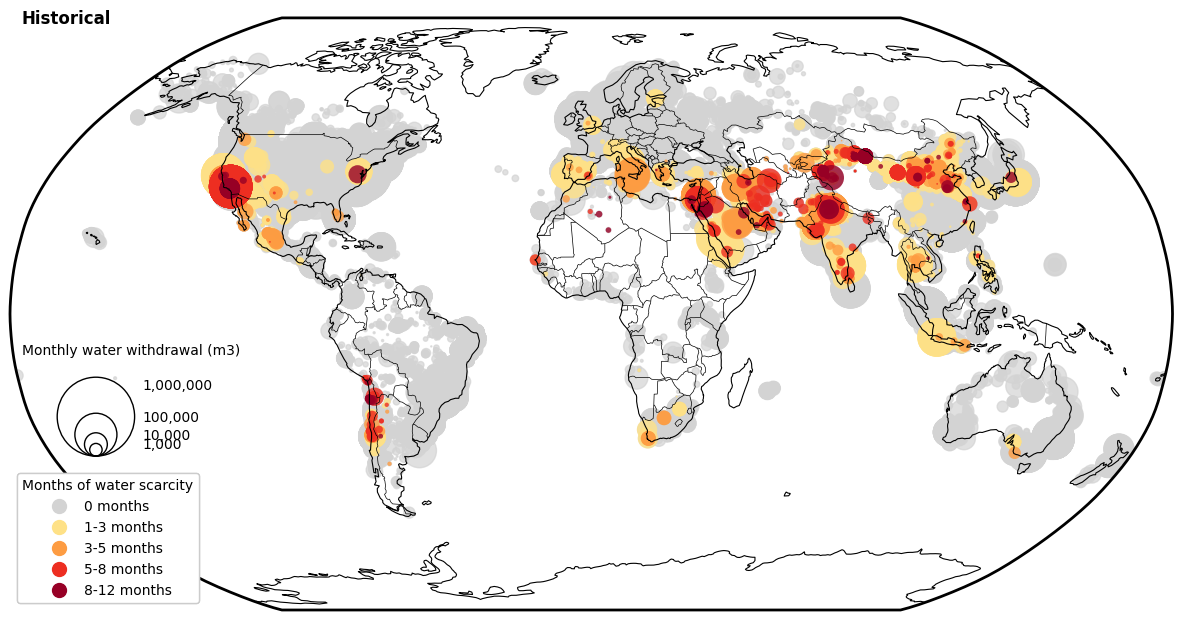

In [95]:
# Filter for operational data centers
water_scarcity_summary_operational = {
    key: val[val["operational"]] for key, val in water_scarcity_summary.items()
}

# Months of water scarcity for operational data centers
plot_months_ws_at_extraction_sites(
    water_scarcity_summary_operational['hist'],
    FIGURES_DIR,
    "hist",
    "months_WSI",
    save=True,
)

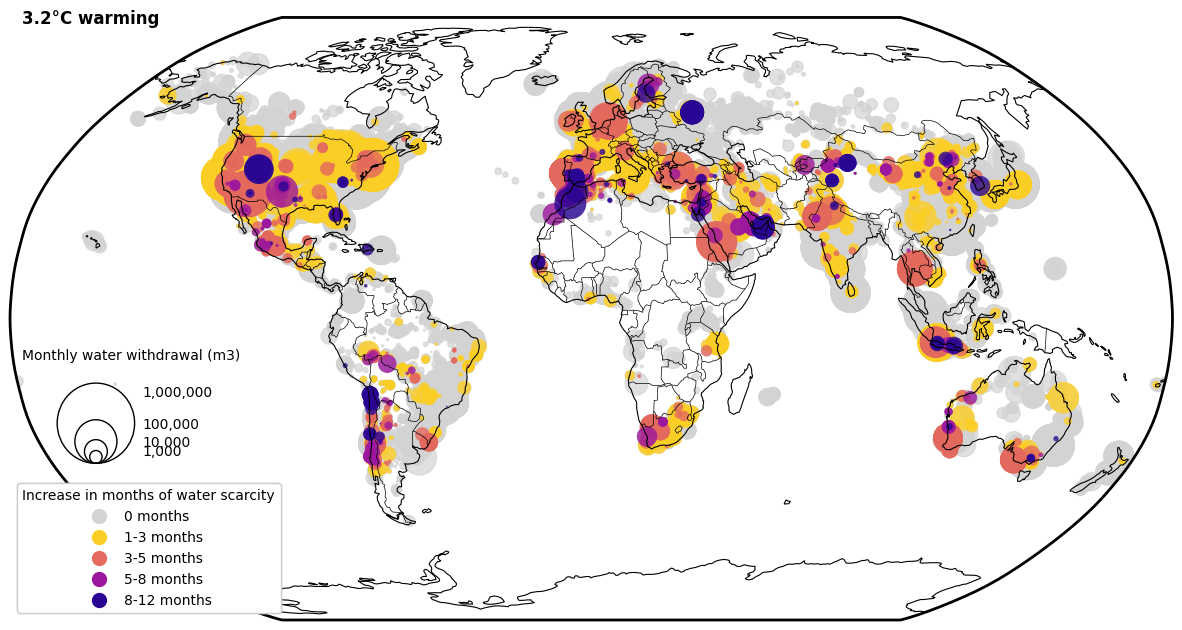

In [ ]:
# for 3.2C scenario
plot_months_ws_at_extraction_sites(
    water_scarcity_summary["3_2C"],
    FIGURES_DIR,
    "3_2C",
    "months_WSI_increase",
    save=True,
)

### Water scarcity boxplot of data center sites at increased risk under cliamte change

Total capacity at risk for 1.5°C: 20 %
Total capacity at risk for 2.0°C: 22 %
Total capacity at risk for 3.2°C: 29 %


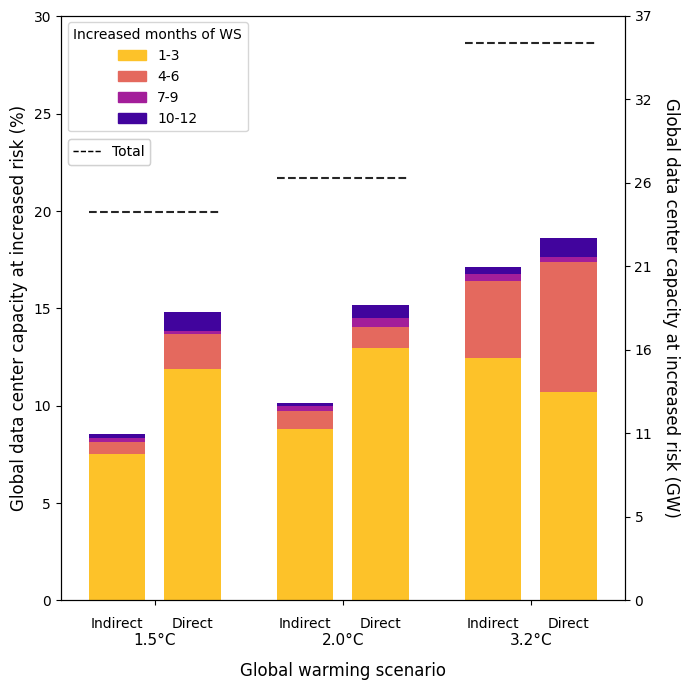

In [11]:
make_capacity_at_risk_boxplot(
    water_scarcity_summary,
    water_scarcity_summary_dc,
    power_plants,
    GLOBAL_WARMING_SCENARIOS_FUTURE,
    FIGURES_DIR,
    fig_name="computing_capacity_increased_ws_risk_barchart.png",
    geographical_scope="Global",
    show_error_bars=False
)

### Constributions of data centers to water scarcity

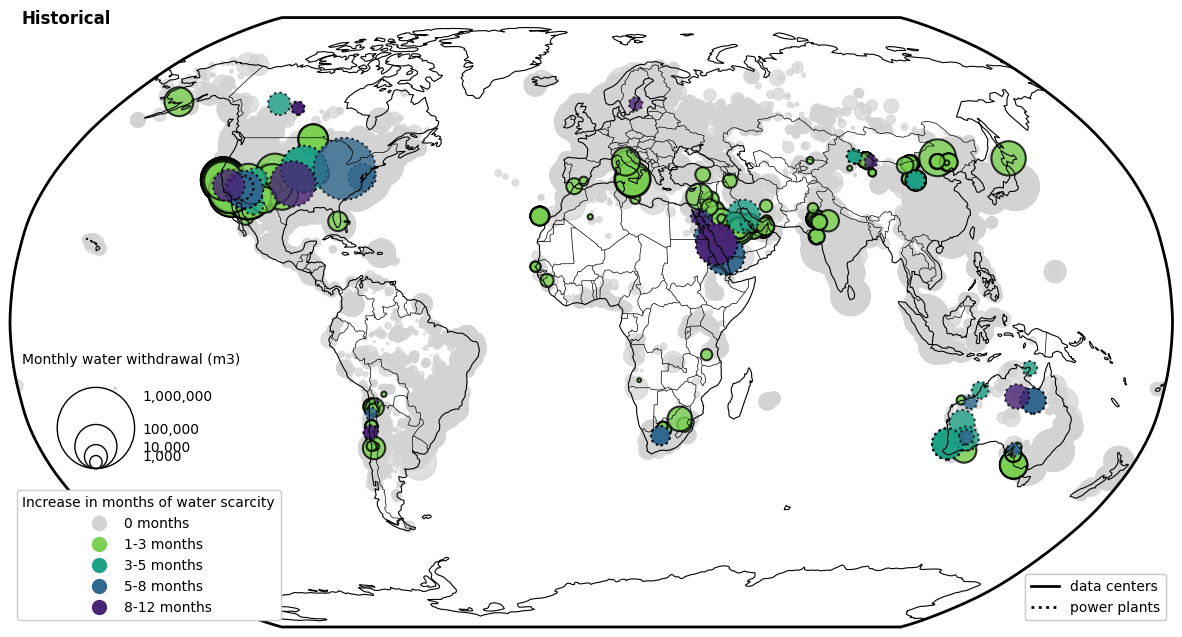

In [8]:
# for historical scenario
plot_months_ws_at_extraction_sites(
    water_scarcity_summary["hist"],
    FIGURES_DIR,
    "hist",
    "dc_direct_increase_months_count",
    include_dc_contributions=True,
    save=False
)

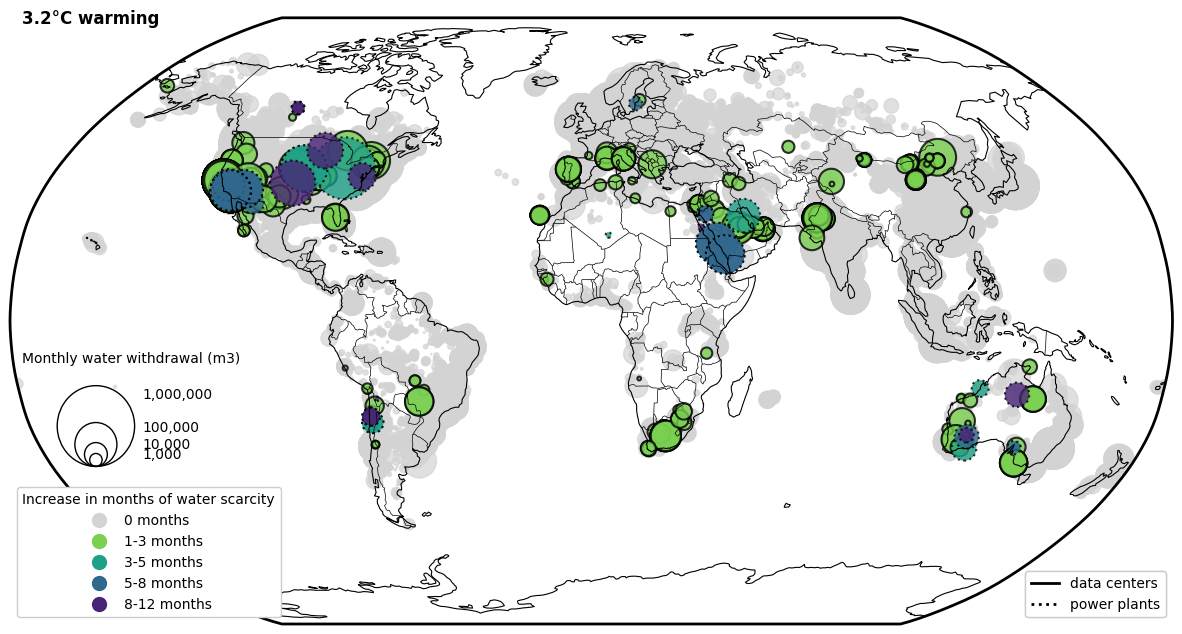

In [9]:
# for 3.2C scenario
plot_months_ws_at_extraction_sites(
    water_scarcity_summary["3_2C"],
    FIGURES_DIR,
    "3_2C",
    "dc_direct_increase_months_count",
    include_dc_contributions=True,
    save=True
)

### Bar chart of the percent of data centers which exacerbate or tip water scarcity risk


In [31]:
# Declare the count of all data centers
total_dc = water_scarcity_summary_dc["3_2C"].shape[0]

# Find the percent of data centers which tip the region into water scarcity
tip_into_water_scarcity_counts = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})
error_tip_into_water_scarcity = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})

for month in range(1, 13):
    tip_into_water_scarcity_counts[f"{month} month"] = [
        100
        * (
            water_scarcity_summary_dc[scenario]
            .loc[
                (water_scarcity_summary_dc[scenario]["months_WSI"] == 0)
                & (water_scarcity_summary_dc[scenario]["months_WSI_dc"] == month)
            ]
            .shape[0]
            / total_dc
        )
        for scenario in GLOBAL_WARMING_SCENARIOS
    ]

    error_tip_into_water_scarcity[f"{month} month"] = [
        abs(
            100
            * (
                water_scarcity_summary_dc[scenario]
                .loc[
                    (water_scarcity_summary_dc[scenario]["months_WSI_0p6"] == 0)
                    & (water_scarcity_summary_dc[scenario]["months_WSI_dc_0p6"] == month)
                ]
                .shape[0]
                / total_dc
                - (
                    water_scarcity_summary_dc[scenario]
                    .loc[
                        (water_scarcity_summary_dc[scenario]["months_WSI"] == 0)
                        & (water_scarcity_summary_dc[scenario]["months_WSI_dc"] == month)
                    ]
                    .shape[0]
                    / total_dc
                )
            )
        )
        for scenario in GLOBAL_WARMING_SCENARIOS
    ]


In [32]:
# Find the percent of data centers which exacerbate water scarcity
exacerbate_water_scarcity_counts = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})
error_exacerbate_water_scarcity = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})

for month in range(1, 13):
    exacerbate_water_scarcity_counts[f"{month} month"] = [
        100 * (df.loc[(df["months_WSI"] > 0) & ((df["months_WSI_dc"] - df["months_WSI"]) == month)].shape[0] / total_dc)
        for df in water_scarcity_summary_dc.values()
    ]

    error_exacerbate_water_scarcity[f"{month} month"] = [
        abs(
            100
            * (
                df.loc[(df["months_WSI_0p6"] > 0) & ((df["months_WSI_dc_0p6"] - df["months_WSI_0p6"]) == month)].shape[
                    0
                ]
                / total_dc
                - (
                    df.loc[(df["months_WSI"] > 0) & ((df["months_WSI_dc"] - df["months_WSI"]) == month)].shape[0]
                    / total_dc
                )
            )
        )
        for df in water_scarcity_summary_dc.values()
    ]


In [33]:
# Declare the count of all power plants
total_pp = water_scarcity_summary_pp["3_2C"].shape[0]

# Initialize DataFrames for results
tip_into_water_scarcity_counts_pp = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})
error_tip_into_water_scarcity_pp = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})
exacerbate_water_scarcity_counts_pp = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})
error_exacerbate_water_scarcity_pp = pd.DataFrame({"Scenario": GLOBAL_WARMING_SCENARIOS})

# Define scenarios list
scenarios_pp = [water_scarcity_summary_pp[scenario] for scenario in GLOBAL_WARMING_SCENARIOS]

# Calculate percentages and errors for each month
for month in range(1, 13):
    tip_into_water_scarcity_counts_pp[f"{month} month"] = [
        100 * (scenario.loc[(scenario["months_WSI"] == 0) & (scenario["months_WSI_dc"] == month)].shape[0] / total_pp)
        for scenario in scenarios_pp
    ]

    error_tip_into_water_scarcity_pp[f"{month} month"] = [
        abs(
            100
            * (
                scenario.loc[(scenario["months_WSI_0p6"] == 0) & (scenario["months_WSI_dc_0p6"] == month)].shape[0]
                / total_pp
                - (
                    scenario.loc[(scenario["months_WSI"] == 0) & (scenario["months_WSI_dc"] == month)].shape[0]
                    / total_pp
                )
            )
        )
        for scenario in scenarios_pp
    ]

    exacerbate_water_scarcity_counts_pp[f"{month} month"] = [
        100
        * (
            scenario.loc[
                (scenario["months_WSI"] > 0) & ((scenario["months_WSI_dc"] - scenario["months_WSI"]) == month)
            ].shape[0]
            / total_pp
        )
        for scenario in scenarios_pp
    ]

    error_exacerbate_water_scarcity_pp[f"{month} month"] = [
        abs(
            100
            * (
                scenario.loc[
                    (scenario["months_WSI_0p6"] > 0)
                    & ((scenario["months_WSI_dc_0p6"] - scenario["months_WSI_0p6"]) == month)
                ].shape[0]
                / total_pp
                - (
                    scenario.loc[
                        (scenario["months_WSI"] > 0) & ((scenario["months_WSI_dc"] - scenario["months_WSI"]) == month)
                    ].shape[0]
                    / total_pp
                )
            )
        )
        for scenario in scenarios_pp
    ]

In [37]:
exacerbate_water_scarcity_counts

Scenario   1 month   2 month   3 month  4 month   5 month  6 month  7 month  \
0     hist  0.834789  1.378373  0.058241      0.0  0.000000      0.0      0.0   
1     1_5C  2.349058  0.058241  0.116482      0.0  0.000000      0.0      0.0   
2     2_0C  0.640652  0.000000  0.077655      0.0  0.000000      0.0      0.0   
3     3_2C  0.873617  0.097069  0.000000      0.0  0.019414      0.0      0.0   

   8 month  9 month  10 month  11 month  12 month  
0      0.0      0.0       0.0       0.0       0.0  
1      0.0      0.0       0.0       0.0       0.0  
2      0.0      0.0       0.0       0.0       0.0  
3      0.0      0.0       0.0       0.0       0.0

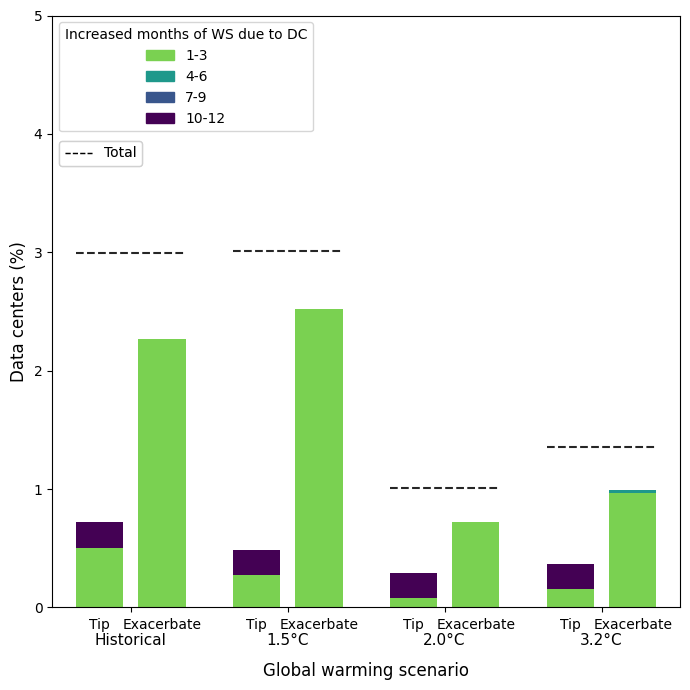

In [34]:
# Bar chart of data centers tipping into and exacerbating water scarcity
plot_exacerbate_tip_water_scarcity_barchart(
    GLOBAL_WARMING_SCENARIOS,
    tip_into_water_scarcity_counts,
    exacerbate_water_scarcity_counts,
    error_tip_into_water_scarcity,
    error_exacerbate_water_scarcity,
    FIGURES_DIR,
    show_error_bars=False
)

## Sensitivity Analyses


### Global electricity and water boxplots across all scenario combinations


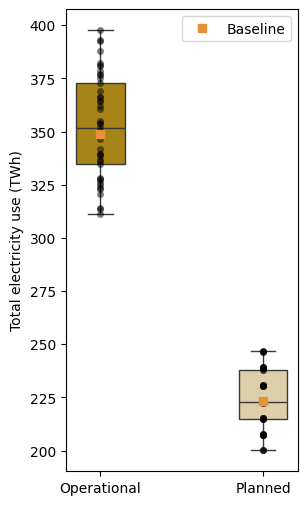

In [18]:
# Create a boxplot showing the total_electricity_use_TWh in the two cases
plt.figure(figsize=(3, 6))
sns.boxplot(
    x=["Operational" if val else "Planned" for val in summary["only_operational"]],
    y=[
        row["total_electricity_use_TWh"] if row["only_operational"] else row["marginal_electricity_increase_TWh"]
        for _, row in summary.iterrows()
    ],
    hue=["Operational" if val else "Planned" for val in summary["only_operational"]],
    palette=["#e4d3a2", "#bf9000"],
    width=0.3,
    legend=False,
)
sns.stripplot(
    x=["Operational" if val else "Planned" for val in summary["only_operational"]],
    y=[
        row["total_electricity_use_TWh"] if row["only_operational"] else row["marginal_electricity_increase_TWh"]
        for _, row in summary.iterrows()
    ],
    color="black",
    alpha=0.5,
    jitter=False,
)
plt.ylabel("Total electricity use (TWh)")
plt.gca().invert_xaxis()

# plot the baseline scenario values in orange squares
plt.plot(
    1,
    baseline_all_scenarios_operational["total_electricity_use_TWh"],
    "s",
    color="#e69138",
    label="Baseline",
    markersize=6,
    zorder=5,
)
plt.plot(
    0, baseline_all_scenarios_planned["marginal_electricity_increase_TWh"], "s", color="#e69138", markersize=6, zorder=5
)
plt.legend()

plt.savefig(FIGURES_DIR / "electricity_use_boxplot.png", dpi=300)

### ANOVA sensitivity analyses

For direct, indirect, and total water use


In [19]:
# Peform a type II ANOVA to determine the variance proportions of total, direct, and indirect water use
# Use all data points, not just the operational ones
summary = summary[~summary["only_operational"]]

# Define formulas and fit models
formulas = {  # C() is used to indicate categorical variables
    "direct_water_use_m3": "direct_water_use_m3 ~ C(power_scenario) + C(tech_performance) + C(cooling_tech_scenario)",
    "indirect_water_use_m3": "indirect_water_use_m3 ~ C(power_scenario) + C(tech_performance) + C(cooling_tech_scenario)",
    "total_water_use_m3": "total_water_use_m3 ~ C(power_scenario) + C(tech_performance) + C(cooling_tech_scenario)",
}

anova_tables = {key: sm.stats.anova_lm(ols(formula, data=summary).fit(), typ=2) for key, formula in formulas.items()}

# Calculate variance proportions
variance_proportions = {
    key: (anova_table["sum_sq"].to_numpy() / anova_table["sum_sq"].sum()) * 100
    for key, anova_table in anova_tables.items()
}

# Print the ANOVA tables
for key, anova_table in anova_tables.items():
    print(key)
    print(anova_table)
    print()

direct_water_use_m3
                                sum_sq    df            F        PR(>F)
C(power_scenario)         2.233622e+15   2.0    26.444790  8.592699e-08
C(tech_performance)       4.442029e+17   2.0  5259.105836  3.906435e-45
C(cooling_tech_scenario)  1.607519e+18   4.0  9516.048096  6.841017e-54
Residual                  1.520345e+15  36.0          NaN           NaN

indirect_water_use_m3
                                sum_sq    df             F        PR(>F)
C(power_scenario)         1.890538e+16   2.0   6058.862704  3.080885e-46
C(tech_performance)       2.179703e+17   2.0  69855.877477  2.495962e-65
C(cooling_tech_scenario)  1.780545e+16   4.0   2853.176173  1.711152e-44
Residual                  5.616514e+13  36.0           NaN           NaN

total_water_use_m3
                                sum_sq    df             F        PR(>F)
C(power_scenario)         3.412120e+16   2.0    378.973142  6.564548e-25
C(tech_performance)       1.284466e+18   2.0  14266.149409  6.4198

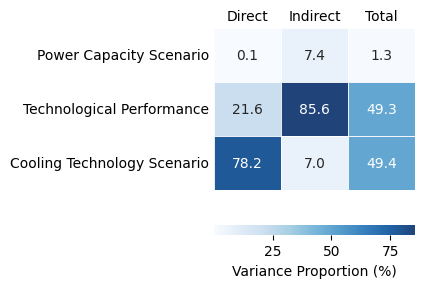

In [20]:
# Plot the variance proportions as a heatmap
# Create DataFrame for heatmap
combined_heatmap_df = pd.DataFrame(
    np.vstack(list(variance_proportions.values())),
    columns=anova_tables["total_water_use_m3"].index,
    index=["Direct", "Indirect", "Total"],
)

# Plot heatmap
fig, ax1 = plt.subplots(1, 1, figsize=(2.6, 3))
sns.heatmap(
    combined_heatmap_df.iloc[:, :-1].T,
    annot=True,
    cmap="Blues",
    fmt=".1f",
    cbar=True,
    alpha=0.9,
    cbar_kws={"label": "Variance Proportion (%)", "orientation": "horizontal"},
    linewidths=0.5,
    ax=ax1,
    yticklabels=["Power Capacity Scenario", "Technological Performance", "Cooling Technology Scenario"],
)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position("top")
ax1.tick_params(length=0)
plt.xticks(rotation=0)
ax1.set_xlabel("")
plt.savefig(FIGURES_DIR / "variance_proportion_water_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()


For variations in WUE and PUE values across data centers


In [21]:
# Load average WUE and PUE results
average_wue_pue = pd.read_csv(RESULTS_DIR / "2_energy_and_water_use/data_centers_average_PUE_WUE_summary.csv")
# Account for operational and planned data centers
average_wue_pue = average_wue_pue[~average_wue_pue["only_operational"]]

In [22]:
# Define formulas for the models
formulas = {
    "electricity_use_efficiency_MWh_MWh": "electricity_use_efficiency_MWh_MWh ~ C(tech_performance) + C(cooling_tech_scenario) + C(ashrae_zone) + C(size)",
    "water_use_efficiency_m3_MWh": "water_use_efficiency_m3_MWh ~ C(tech_performance) + C(cooling_tech_scenario) + C(ashrae_zone) + C(size)",
}

# Fit models and perform ANOVA
anova_tables = {
    key: sm.stats.anova_lm(ols(formula, data=average_wue_pue).fit(), typ=2) for key, formula in formulas.items()
}

# Calculate variance proportions
variance_proportions = {
    key: (anova_table["sum_sq"].to_numpy() / anova_table["sum_sq"].sum()) * 100
    for key, anova_table in anova_tables.items()
}


# Print the ANOVA tables
for key, anova_table in anova_tables.items():
    print(key)
    print(anova_table)
    print()

electricity_use_efficiency_MWh_MWh
                             sum_sq      df            F         PR(>F)
C(tech_performance)        9.198932     2.0  1190.201027   0.000000e+00
C(cooling_tech_scenario)   2.447509     4.0   158.335090  1.376571e-115
C(ashrae_zone)             5.397206    12.0   116.385978  2.578749e-212
C(size)                   25.154681     2.0  3254.630725   0.000000e+00
Residual                   6.700947  1734.0          NaN            NaN

water_use_efficiency_m3_MWh
                              sum_sq      df            F         PR(>F)
C(tech_performance)        86.217112     2.0   327.206703  2.720365e-121
C(cooling_tech_scenario)  912.581067     4.0  1731.690117   0.000000e+00
C(ashrae_zone)             12.382856    12.0     7.832462   2.217814e-14
C(size)                    23.678894     2.0    89.864906   7.329328e-38
Residual                  228.449587  1734.0          NaN            NaN



/Users/Wient003/Library/CloudStorage/OneDrive-UniversiteitUtrecht/DC Paper/data-center-water-footprint/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/Wient003/Library/CloudStorage/OneDrive-UniversiteitUtrecht/DC Paper/data-center-water-footprint/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/Wient003/Library/CloudStorage/OneDrive-UniversiteitUtrecht/DC Paper/data-center-water-footprint/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/Wient003/Library/CloudStorage/OneDrive-UniversiteitUtrecht/DC Paper/data-center-water-footprint/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Us

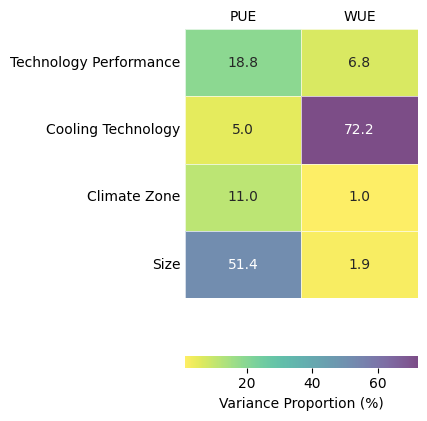

In [23]:
# Plot the variance proportions as a heatmap
# Prepare data for heatmap
combined_heatmap_data = np.vstack(list(variance_proportions.values()))
combined_heatmap_df = pd.DataFrame(
    combined_heatmap_data, columns=anova_tables["electricity_use_efficiency_MWh_MWh"].index, index=["PUE", "WUE"]
)

# Set up the figure and axes
fig, ax1 = plt.subplots(1, 1, figsize=(3, 5))

# Exclude the last data point (residuals)
heatmap_data = combined_heatmap_df.iloc[:, :-1]

# Plot the heatmap with PUE and WUE labels on top
sns.heatmap(
    heatmap_data.T,
    annot=True,
    cmap="viridis_r",
    fmt=".1f",
    cbar=True,
    alpha=0.7,
    cbar_kws={"label": "Variance Proportion (%)", "orientation": "horizontal"},
    linewidths=0.5,
    ax=ax1,
    yticklabels=["Technology Performance", "Cooling Technology", "Climate Zone", "Size"],
)

# Adjust the heatmap to have the labels on top
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position("top")

# Remove the tick lines
ax1.tick_params(length=0)

# Save the figure
plt.savefig(FIGURES_DIR / "average_wue_pue_heatmap.png", dpi=300, bbox_inches="tight")

plt.show()


## Data center summary plots


Plotting the data centers within countries


In [5]:
# Perform a spatial join on countries
data_centers = gpd.sjoin(data_centers, country_boundaries, how="left")
country_boundaries.loc[country_boundaries.index.isin(data_centers["index_right"].dropna().unique()), "col"] = 2

In [6]:
# Count number unique in ADMIN column 
data_centers['ADMIN'].nunique()

111

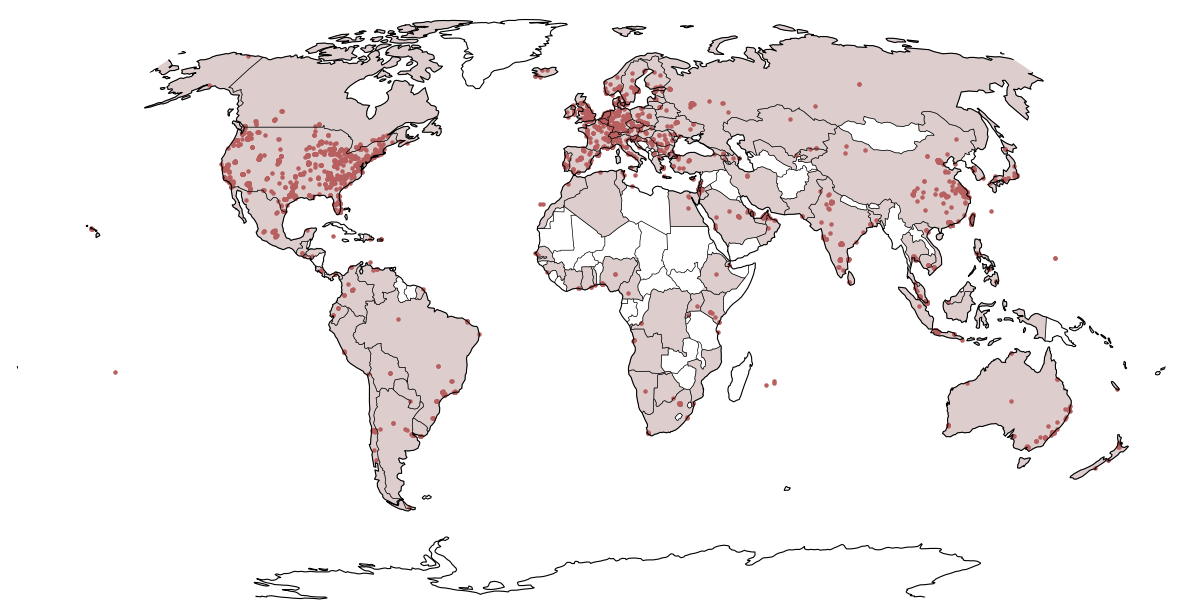

In [28]:
# Plotting data center locations
# Assigning colors
dots_col = "#b86060"  # Dot color
countries_col = "#ddcdcd"  # Country highlight color

# Plot map
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={"projection": ccrs.Robinson()})

# Main map settings
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor="white", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Set global extent
ax.set_global()
ax.spines["geo"].set_edgecolor("black")
ax.spines["geo"].set_linewidth(2)

country_boundaries.plot(ax=ax, color="white", edgecolor="grey", linewidth=0.3)
country_boundaries[country_boundaries["col"] == 2].plot(
    ax=ax, color=countries_col, transform=ccrs.PlateCarree(), edgecolor="grey", linewidth=0.3
)
data_centers.plot(ax=ax, transform=ccrs.PlateCarree(), color=dots_col, markersize=5)

# remove axis
ax.axis("off")

# Save the plot
plt.savefig(FIGURES_DIR / "data_center_locations.png", dpi=300, bbox_inches="tight")

Plotting a barchart of the data centers by continent


In [50]:
# Get the continent from the country code
data_centers["Continent"] = data_centers["ISO_A3_left"].apply(get_continent_from_country)

In [ ]:
# Plot the number of data centers per continent in a stacked bar chart
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Set colors
dots_col_operational = "#b86060"  # Operational data centers color
dots_col_planned = "#ddcdcd"  # Planned data centers color

# Count the number of operational and planned data centers per continent
operational_counts = data_centers[data_centers["operational"]]["Continent"].value_counts()
planned_counts = data_centers[~data_centers["operational"]]["Continent"].value_counts()

# Combine the counts into a single DataFrame
counts = pd.DataFrame({"operational": operational_counts, "Planned": planned_counts}).fillna(0)

# Plot the stacked bar chart
counts.plot(kind="bar", stacked=True, ax=ax, color=[dots_col_operational, dots_col_planned])

# Translate continent codes to names
continents = {
    "AF": "Africa",
    "AS": "Asia",
    "EU": "Europe",
    "NA": "North America",
    "OC": "Oceania",
    "SA": "South America",
}

# Add labels
ax.set_xticklabels([continents[continent] for continent in counts.index], rotation=0)
ax.set_ylabel("Number of data centers")
ax.set_xlabel("Continent")

# Add labels to the bars
for i in range(len(counts)):
    op = counts["operational"][i]
    pl = counts["Planned"][i]
    ax.text(i, op + pl / 2, str(int(pl)), color="black", ha="center", va="center")
    ax.text(i, op / 2, str(int(op)), color="black", ha="center", va="center")

# Save the plot
plt.savefig(FIGURES_DIR / "data_centers_per_continent.png", dpi=300, bbox_inches="tight")

## Figures energy and water use by country


In [25]:
# Create a subset of the data to represent the baseline scenario
data_center_energy_water_use = data_center_energy_water_use[
    (data_center_energy_water_use["tech_performance"] == "medium")
    & (data_center_energy_water_use["cooling_tech_scenario"] == "most_common")
    & (data_center_energy_water_use["power_scenario"] == "avg")
]

# Remove the index_right column
data_center_energy_water_use = data_center_energy_water_use.drop(columns="index_right")

# Perform a spatial join on countries
data_center_energy_water_use = gpd.sjoin(
    data_center_energy_water_use,
    country_boundaries,
    how="inner",
    predicate="within",
)

In [26]:
# Find the energy use per country
energy_use_per_country = country_boundaries.merge(
    data_center_energy_water_use.groupby("ADMIN").agg({"annual_electricity_use_MWh": "sum"}).reset_index(),
    on="ADMIN",
    how="left",
)

# Convert energy use from MWh to TWh
energy_use_per_country["annual_electricity_use_TWh"] = energy_use_per_country["annual_electricity_use_MWh"] / 1_000_000

# Apply log transformation to the energy use data
energy_use_per_country["log_annual_electricity_use_TWh"] = np.log10(
    energy_use_per_country["annual_electricity_use_TWh"]
)

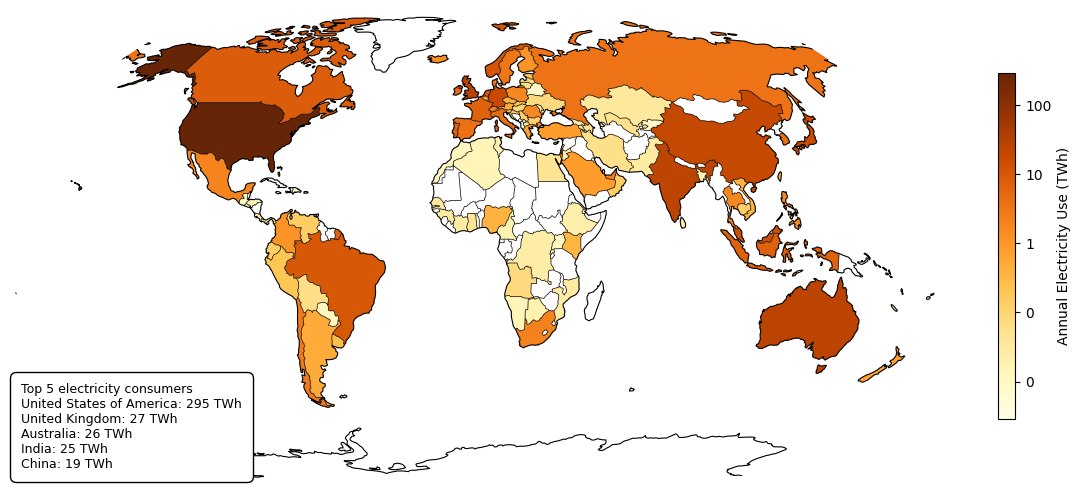

In [27]:
# Plot the energy use per country in log scale
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={"projection": ccrs.Robinson()})
country_boundaries.boundary.plot(ax=ax, color="black", linewidth=0.5)
energy_use_per_country.plot(
    column="log_annual_electricity_use_TWh",
    ax=ax,
    transform=ccrs.PlateCarree(),
    legend=True,
    cmap="YlOrBr",
    legend_kwds={"label": "Annual Electricity Use (TWh)", "shrink": 0.3},
)

# Main map settings
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor="white", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Set global extent
ax.set_global()
ax.spines["geo"].set_edgecolor("black")
ax.spines["geo"].set_linewidth(2)


# Modify the legend to show untransformed values
cbar = ax.get_figure().get_axes()[1]
ticks_loc = cbar.get_yticks()
cbar.yaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
cbar.set_yticklabels([f"{10**tick:.0f}" for tick in ticks_loc])

# Create an extra box with the top 5 countries by energy use in TWh
top_5_energy_use = energy_use_per_country.nlargest(5, "annual_electricity_use_TWh")
top_5_energy_use["text"] = (
    top_5_energy_use["ADMIN"]
    + ": "
    + top_5_energy_use["annual_electricity_use_TWh"].round(0).astype(int).astype(str)
    + " TWh"
)
textstr = "\n".join(top_5_energy_use["text"])

# Create a legend box
anchored_text = AnchoredText(
    "Top 5 electricity consumers\n" + textstr,
    loc="lower left",
    prop={"size": 9},
    frameon=True,
)
anchored_text.patch.set_boxstyle("round,pad=0.5,rounding_size=0.5")
ax.add_artist(anchored_text)

# Remove the axis
ax.set_axis_off()

# Save the plot
plt.savefig(FIGURES_DIR / "data_center_energy_use_by_country.png", dpi=300, bbox_inches="tight")

In [28]:
# Find the water use per country
water_use_per_country = country_boundaries.merge(
    data_center_energy_water_use.groupby("ADMIN").agg({"total_water_use_m3": "sum"}).reset_index(),
    on="ADMIN",
    how="left",
)
# Convert water use from m3 to million m3
water_use_per_country["water_use_million_m3"] = water_use_per_country["total_water_use_m3"] / 1_000_000

# Apply log transformation to the water use data
water_use_per_country["log_water_use_million_m3"] = np.log10(water_use_per_country["water_use_million_m3"])

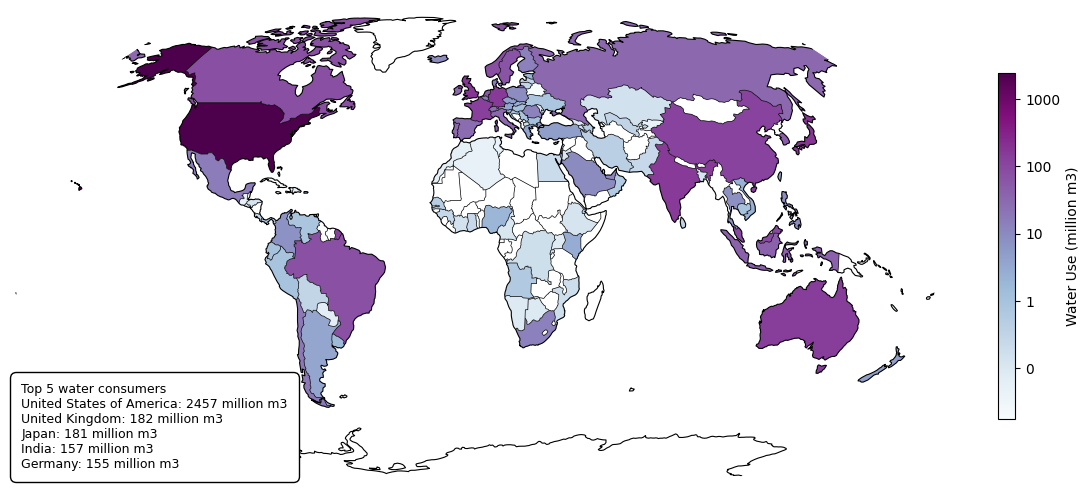

In [29]:
# Plot the water use per country in log scale
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={"projection": ccrs.Robinson()})
country_boundaries.boundary.plot(ax=ax, color="black", linewidth=0.5)
water_use_per_country.plot(
    column="log_water_use_million_m3",
    ax=ax,
    transform=ccrs.PlateCarree(),
    legend=True,
    cmap="BuPu",
    legend_kwds={"label": "Water Use (million m3)", "shrink": 0.3},
)

# Main map settings
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor="white", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Set global extent
ax.set_global()
ax.spines["geo"].set_edgecolor("black")
ax.spines["geo"].set_linewidth(2)


# Modify the legend to show untransformed values
cbar = ax.get_figure().get_axes()[1]
ticks_loc = cbar.get_yticks()
cbar.yaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
cbar.set_yticklabels([f"{10**tick:.0f}" for tick in ticks_loc])

# Create an extra box with the top 5 countries by water use in million m3
top_5_water_use = water_use_per_country.nlargest(5, "water_use_million_m3")
top_5_water_use["text"] = (
    top_5_water_use["ADMIN"]
    + ": "
    + top_5_water_use["water_use_million_m3"].round(0).astype(int).astype(str)
    + " million m3"
)
textstr = "\n".join(top_5_water_use["text"])

# Create a legend box
anchored_text = AnchoredText(
    "Top 5 water consumers\n" + textstr,
    loc="lower left",
    prop={"size": 9},
    frameon=True,
)
anchored_text.patch.set_boxstyle("round,pad=0.5,rounding_size=0.5")
ax.add_artist(anchored_text)

# Remove the axis
ax.set_axis_off()

# Save the plot
plt.savefig(FIGURES_DIR / "data_center_water_use_by_country.png", dpi=300, bbox_inches="tight")

# Mapping water use per basin


In [36]:
# Read the watershed sub-basin shapefile
basins_level5 = gpd.read_file(INPUTS_DIR / "BasinATLAS_Data_v10/BasinATLAS_v10_lev05.shp", crs=WGS84_CRS)

# Read in the water use data
water_use_dcs_pps = read_gdf_from_csv(RESULTS_DIR / "2_energy_and_water_use/water_use_dcs_pps_baseline.csv")
water_use_dcs_pps_operational = read_gdf_from_csv(
    RESULTS_DIR / "2_energy_and_water_use/water_use_dcs_pps_operational_baseline.csv"
)
water_use_dcs_pps_planned = read_gdf_from_csv(
    RESULTS_DIR / "2_energy_and_water_use/water_use_dcs_pps_planned_baseline.csv"
)

/Users/Wient003/Library/CloudStorage/OneDrive-UniversiteitUtrecht/DC Paper/data-center-water-footprint/.venv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


In [37]:
# Spatial join the water use data to the basins to calculate water use by basin
water_use_per_basin_operational = calculate_water_use_by_basin(water_use_dcs_pps_operational, basins_level5)
water_use_per_basin_planned = calculate_water_use_by_basin(water_use_dcs_pps_planned, basins_level5)

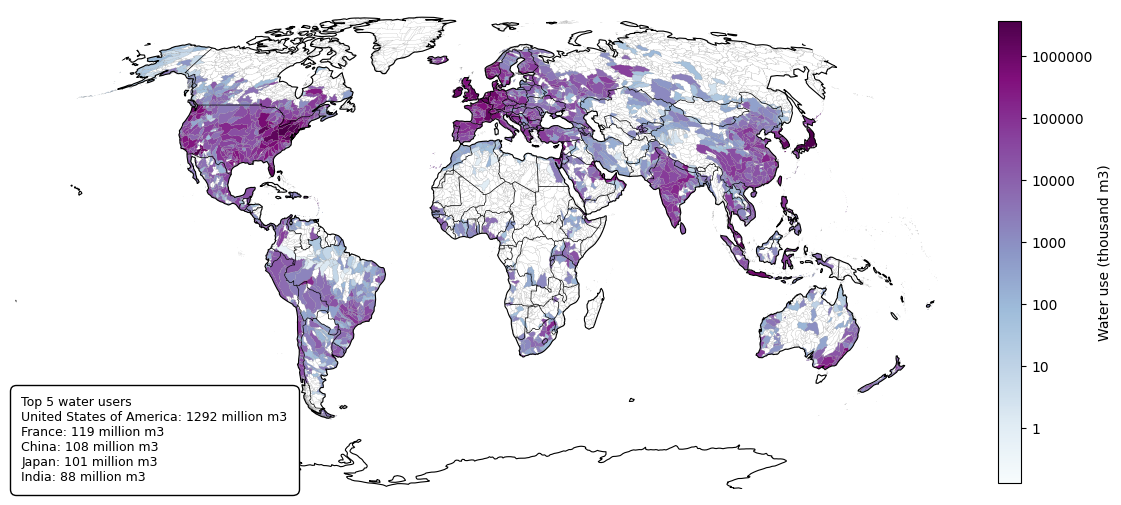

In [38]:
# Plot the water use map for operational data centers
plot_water_use_map(
    water_use_per_basin_operational,
    basins_level5,
    data_center_energy_water_use,
    figure_dir=FIGURES_DIR,
    status="operational",
    figsize=(15, 15),
    cmap="BuPu",
)

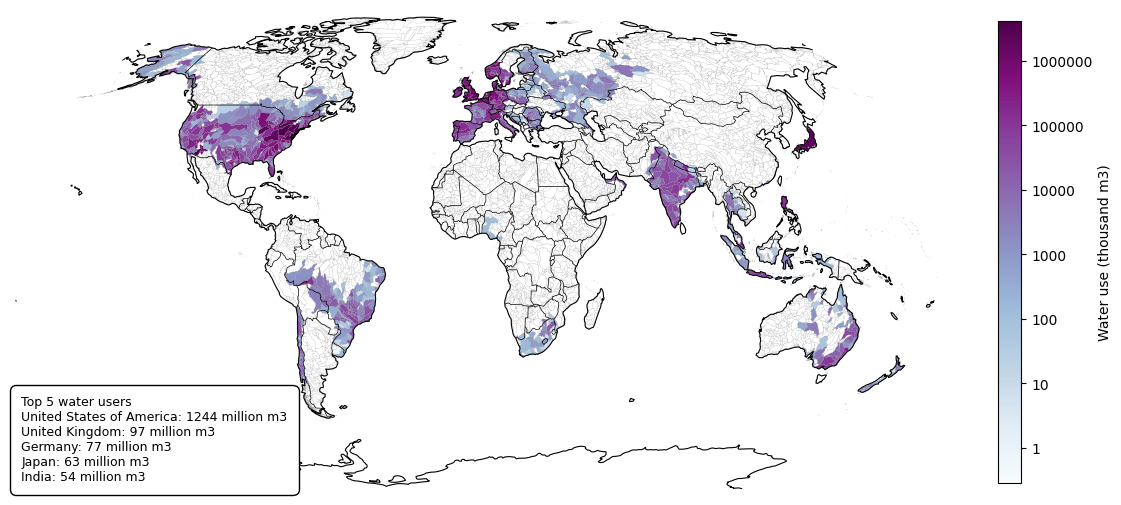

In [39]:
# Plot the water use map for planned data centers
plot_water_use_map(
    water_use_per_basin_planned,
    basins_level5,
    data_center_energy_water_use,
    figure_dir=FIGURES_DIR,
    status="planned",
    figsize=(15, 15),
    cmap="BuPu",
)

In [40]:
# What percent of basins have non-missing water use data?
percent_not_missing = 100 * water_use_per_basin_operational["dc_annual_water_use_m3"].notna().sum() / len(basins_level5)
print(f"Percent of basins with data center water use: {percent_not_missing:.2f}%")

Percent of basins with data center water use: 37.92%


## Data center vulnerability to water scarcity figures


Mapping the areas with the greatest increases in water scarcity risk


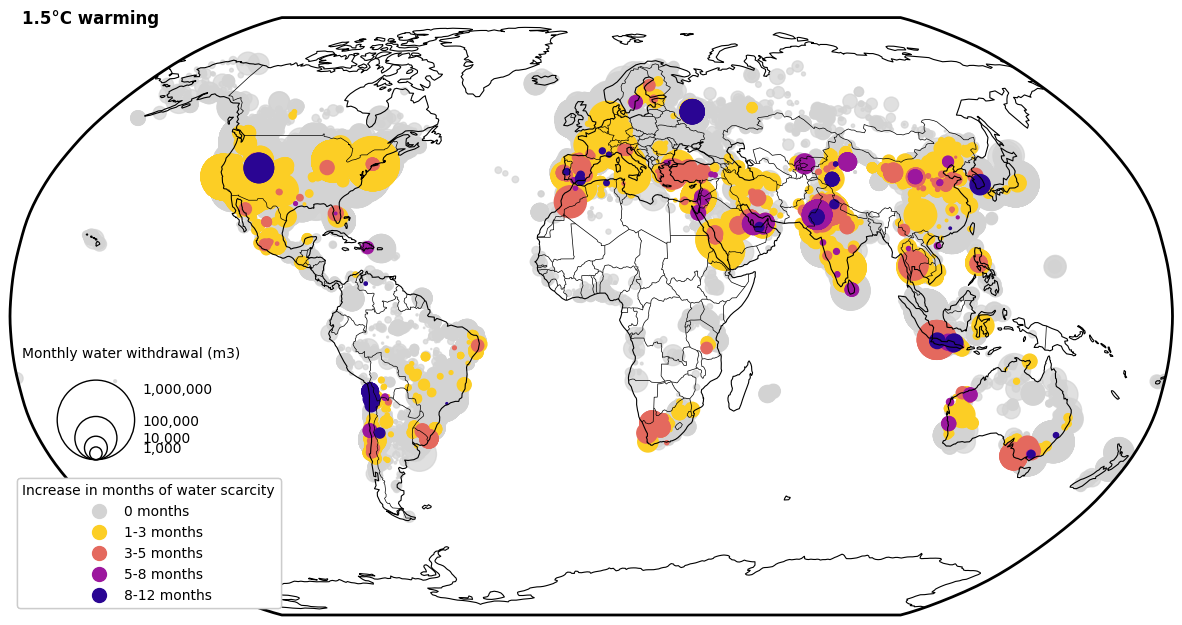

In [30]:
# for 1.5C scenario
plot_months_ws_at_extraction_sites(
    water_scarcity_summary["1_5C"],
    FIGURES_DIR,
    "1_5C",
    "months_WSI_increase",
)

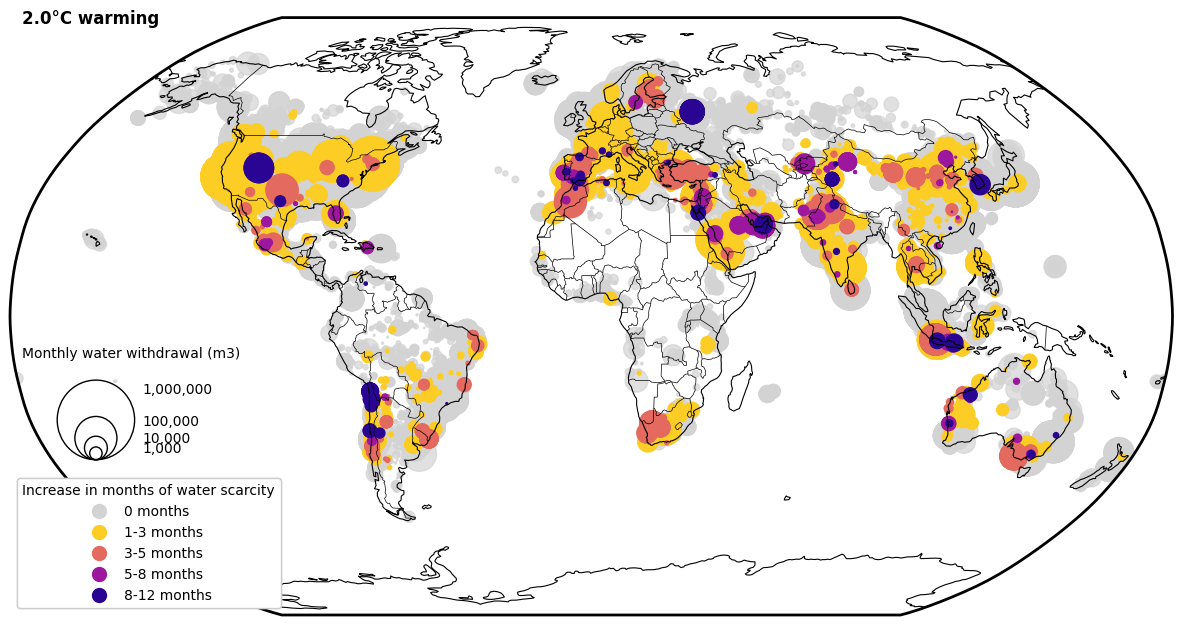

In [31]:
# for 2.0C scenario
plot_months_ws_at_extraction_sites(
    water_scarcity_summary["2_0C"],
    FIGURES_DIR,
    "2_0C",
    "months_WSI_increase",
)

Plotting a barchart of the total capacity at increased risk


Total capacity at risk for 1.5°C: 20 %
Total capacity at risk for 2.0°C: 22 %
Total capacity at risk for 3.2°C: 29 %


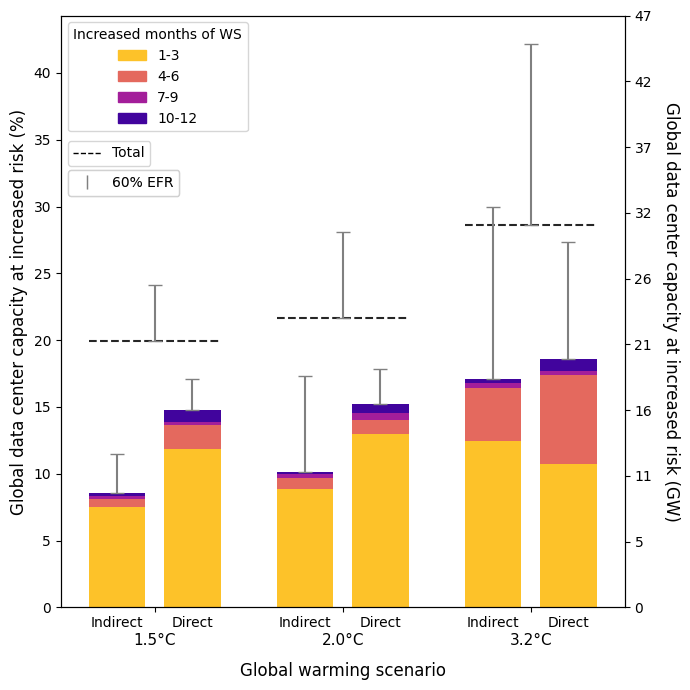

In [43]:
# With 60% EFR error bars
make_capacity_at_risk_boxplot(
    water_scarcity_summary,
    water_scarcity_summary_dc,
    power_plants,
    GLOBAL_WARMING_SCENARIOS_FUTURE,
    FIGURES_DIR,
    fig_name="computing_capacity_increased_ws_risk_barchart_error_bars.png",
    geographical_scope="Global",
    show_error_bars=True
)

In [ ]:
# Assign country codes to data centers
for scenario in GLOBAL_WARMING_SCENARIOS:
    right_gdf = country_boundaries[['ISO_A3', 'geometry']]
    water_scarcity_summary[scenario] = gpd.sjoin(
        water_scarcity_summary[scenario],
        right_gdf,
        how="left",
        predicate="within",
    )
    water_scarcity_summary_dc[scenario] = gpd.sjoin(
        water_scarcity_summary_dc[scenario],
        right_gdf,
        how="left",
        predicate="within",
    )


power_plants = gpd.sjoin(
    power_plants,
    country_boundaries[['ISO_A3', 'geometry']],
    how="left",
    predicate="within",
)


In [53]:
def filter_by_country(data_dict, country, country_column = "country", include=True):
    if include:
        return {scenario: df[df[country_column] == country] for scenario, df in data_dict.items()}
    else:
        return {scenario: df[df[country_column] != country] for scenario, df in data_dict.items()}

In [63]:
# Analyzing risk for US and non-US data centers
water_scarcity_summary_no_US = filter_by_country(water_scarcity_summary, "USA", "ISO_A3", include=False)
water_scarcity_summary_dc_no_US = filter_by_country(water_scarcity_summary_dc, "USA", "ISO_A3", include=False)
power_plants_no_US = power_plants[power_plants["ISO_A3"] != "USA"]
water_scarcity_summary_US = filter_by_country(water_scarcity_summary, "USA", "ISO_A3", include=True)
water_scarcity_summary_dc_US = filter_by_country(water_scarcity_summary_dc, "USA", "ISO_A3", include=True)
power_plants_US = power_plants[power_plants["ISO_A3"] == "USA"]

Total capacity at risk for 1.5°C: 20 %
Total capacity at risk for 2.0°C: 23 %
Total capacity at risk for 3.2°C: 31 %


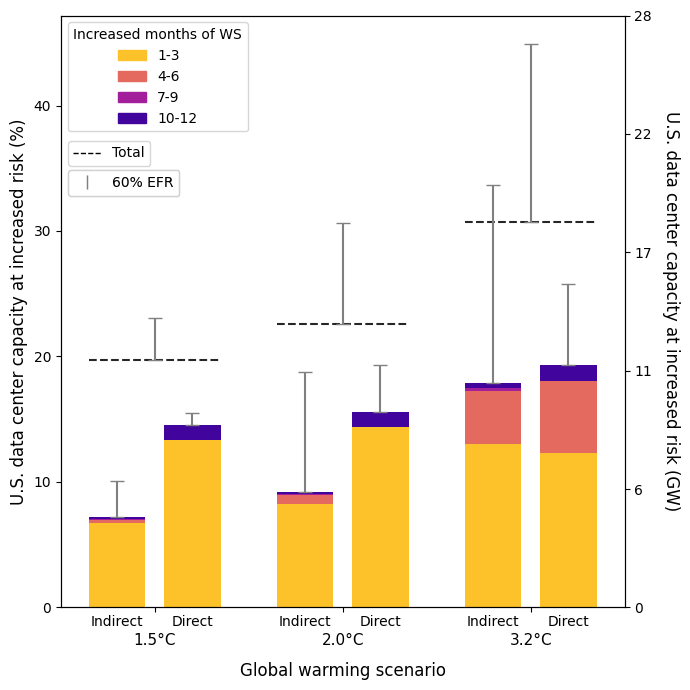

In [64]:
# For US data centers
make_capacity_at_risk_boxplot(
    water_scarcity_summary_US,
    water_scarcity_summary_dc_US,
    power_plants_US,
    GLOBAL_WARMING_SCENARIOS_FUTURE,
    FIGURES_DIR,
    fig_name="computing_capacity_increased_ws_risk_barchart_US.png",
    geographical_scope="U.S.",
    show_error_bars=True
)

Total capacity at risk for 1.5°C: 20 %
Total capacity at risk for 2.0°C: 21 %
Total capacity at risk for 3.2°C: 26 %


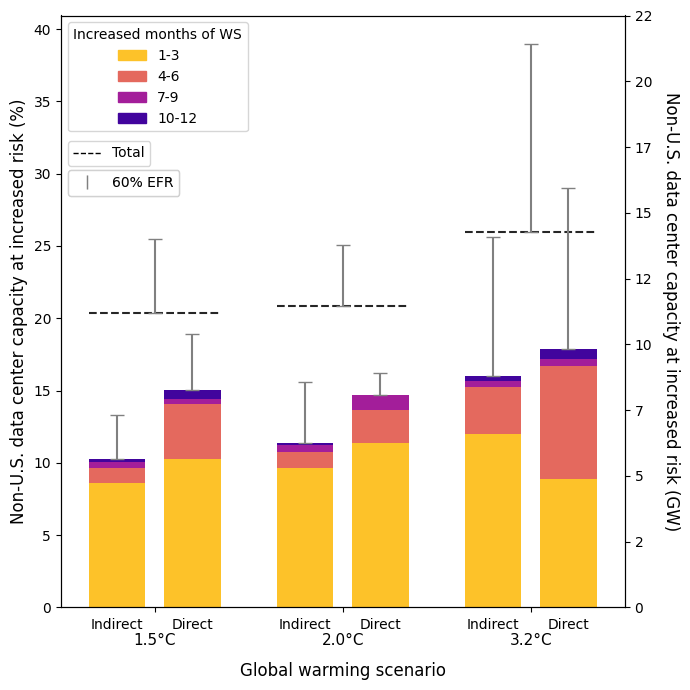

In [65]:
# For non-US data centers
make_capacity_at_risk_boxplot(
    water_scarcity_summary_no_US,
    water_scarcity_summary_dc_no_US,
    power_plants_no_US,
    GLOBAL_WARMING_SCENARIOS_FUTURE,
    FIGURES_DIR,
    fig_name="computing_capacity_increased_ws_risk_barchart_no_US.png",
    geographical_scope="Non-U.S.",
    show_error_bars=True
)

## Data center vulnerability to water shortage figures

Not accounting for EFRs


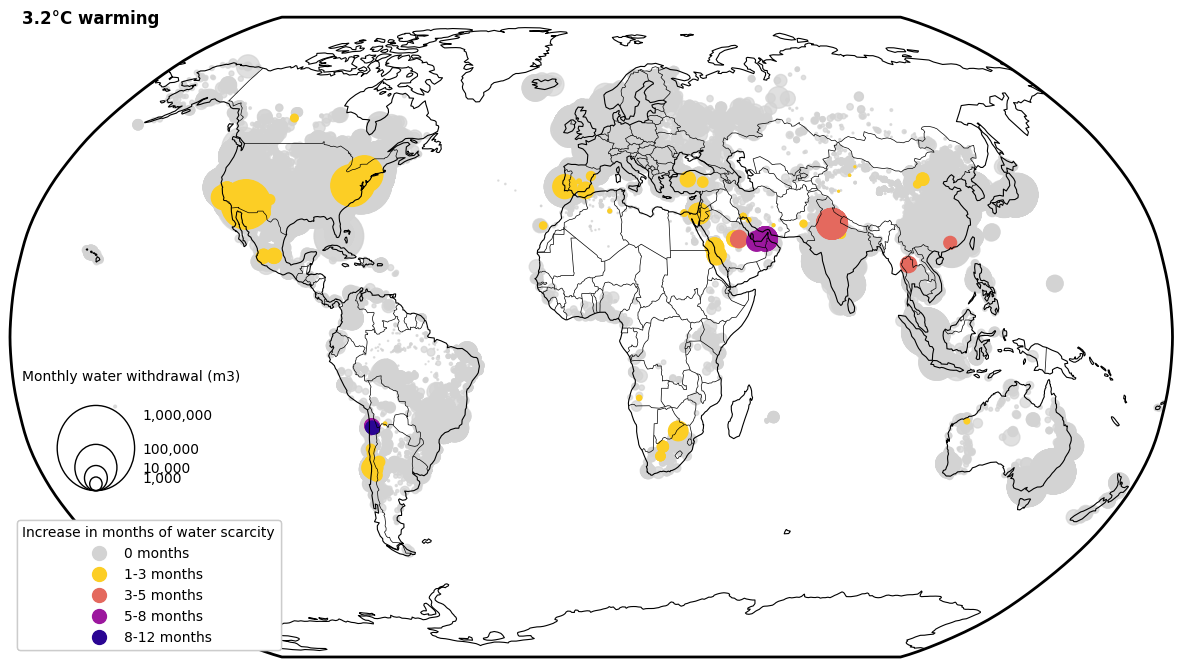

In [66]:
# for 3.2C scenario
plot_months_ws_at_extraction_sites(
    vulnerability_summary[vulnerability_summary["scenario"] == "3_2C"],
    FIGURES_DIR,
    "3_2C",
    "months_vulnerability_increase",
)

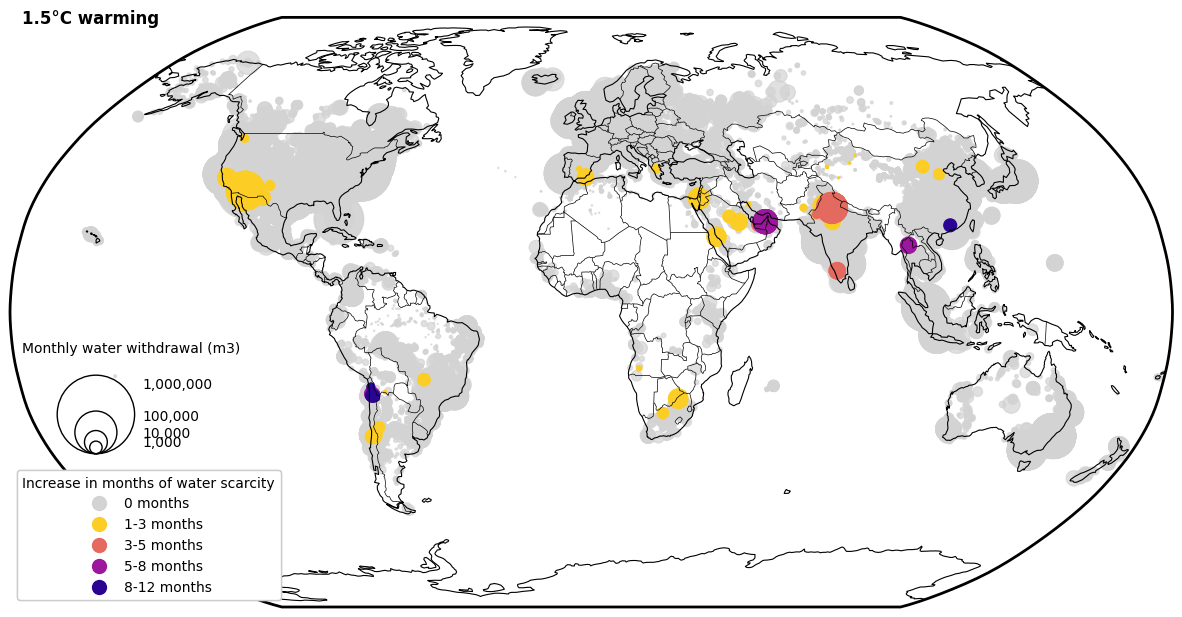

In [67]:
# for 1.5C scenario
plot_months_ws_at_extraction_sites(
    vulnerability_summary[vulnerability_summary["scenario"] == "1_5C"],
    FIGURES_DIR,
    "1_5C",
    "months_vulnerability_increase",
)

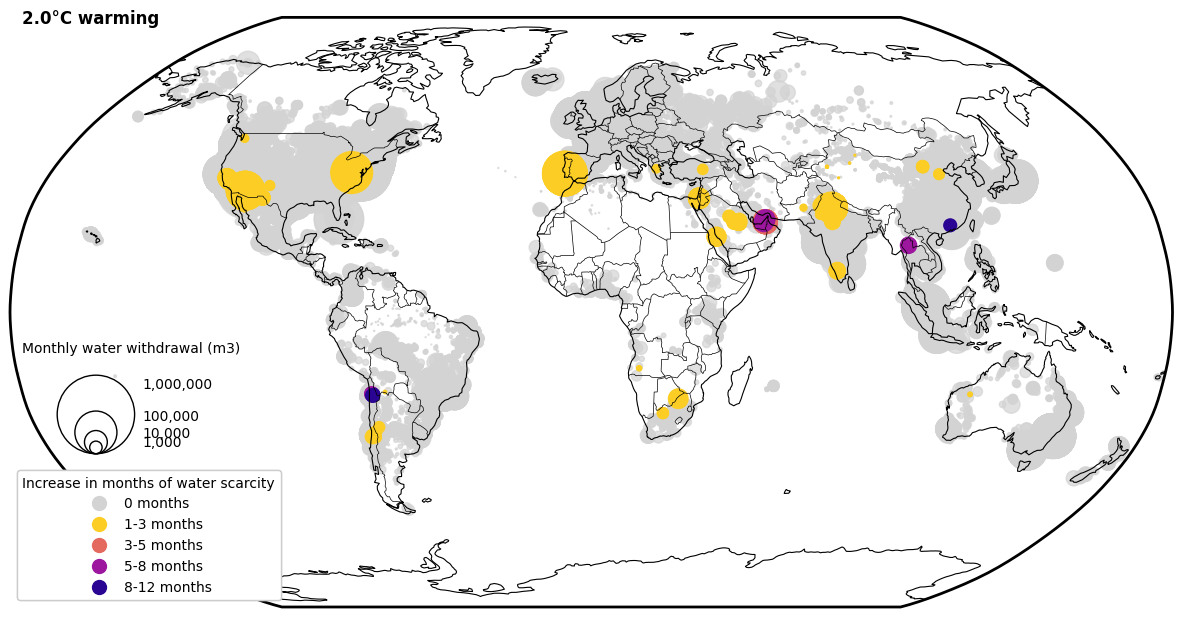

In [68]:
# for 2.0C scenario
plot_months_ws_at_extraction_sites(
    vulnerability_summary[vulnerability_summary["scenario"] == "2_0C"],
    FIGURES_DIR,
    "2_0C",
    "months_vulnerability_increase",
)

Plotting a barchart of the total capacity at increased risk


In [69]:
# Calculate the percentage of months with a vulnerability increase for each scenario
# Define scenarios and their corresponding DataFrames
future_scenarios_dict = {
    "1.5°C": vulnerability_summary[vulnerability_summary["scenario"] == "1_5C"],
    "2.0°C": vulnerability_summary[vulnerability_summary["scenario"] == "2_0C"],
    "3.2°C": vulnerability_summary[vulnerability_summary["scenario"] == "3_2C"],
}

# Initialize results DataFrame
vulnerability_counts_direct = pd.DataFrame({"Scenario": list(future_scenarios_dict.keys())})

# Calculate monthly percentages
for month in range(1, 13):
    vulnerability_counts_direct[f"{month} month"] = [
        100 * (df.loc[df["months_vulnerability_increase"] == month, "tcp_mw"].sum() / df["tcp_mw"].sum())
        for df in future_scenarios_dict.values()
    ]

In [70]:
# Calculate the share of each power plant's capacity that is affected by increased water shortage
vulnerability_dfs = []  # List to store the resulting dataframes

# Iterate through each scenario and calculate the share
for scenario in GLOBAL_WARMING_SCENARIOS_FUTURE:
    df = calculate_pp_increased_ws_share(
        vulnerability_summary[vulnerability_summary["scenario"] == scenario],
        power_plants,
        "vulnerability",
        sensitivity_analysis=False,
    )
    # Append the resulting dataframe to the list
    vulnerability_dfs.append(df)

# Concatenate all the dataframes into one
vulnerability_summary = pd.concat(vulnerability_dfs, ignore_index=True)

In [71]:
# Calculate the total capacity at risk for each data center
vulnerability_dfs = []  # List to store the resulting dataframes

# Iterate through each scenario and calculate the total capacity at risk
for scenario in GLOBAL_WARMING_SCENARIOS_FUTURE:
    df = calculate_total_data_center_capacity_at_risk(
        vulnerability_summary[vulnerability_summary["scenario"] == scenario],
        "vulnerability",
        sensitivity_analysis=False,
    )
    # Append the resulting dataframe to the list
    vulnerability_dfs.append(df)

# Concatenate all the dataframes into one
vulnerability_summary = pd.concat(vulnerability_dfs, ignore_index=True)

In [ ]:
# Calculate the water scarcity increase counts as percentages for each month from 1 to 12
vulnerability_counts_indirect = pd.DataFrame({"Scenario": ["1.5°C", "2.0°C", "3.2°C"]})

for month in range(1, 13):
    vulnerability_counts_indirect[f"{month} month"] = [
        100
        * (
            vulnerability_summary[vulnerability_summary["scenario"] == scenario]
            .loc[
                vulnerability_summary[vulnerability_summary["scenario"] == scenario]["months_vulnerability_increase"]
                == month,
                "tcp_mw_share_pp",
            ]
            .sum()
            / vulnerability_summary[vulnerability_summary["scenario"] == scenario]["tcp_mw_share_pp"].sum()
        )
        for scenario in GLOBAL_WARMING_SCENARIOS_FUTURE
    ]

In [73]:
# Calculate the total global capacity at risk for each scenario
vulnerability_total_capacity_at_risk = pd.DataFrame(
    {
        "Scenario": ["1.5°C", "2.0°C", "3.2°C"],
        "Total_capacity_at_risk": [
            100
            * vulnerability_summary[vulnerability_summary["scenario"] == scenario]["total_capacity_at_risk"].sum()
            / vulnerability_summary[vulnerability_summary["scenario"] == scenario]["tcp_mw"].sum()
            for scenario in GLOBAL_WARMING_SCENARIOS_FUTURE
        ],
    }
)

total_tcp_gw = vulnerability_summary[vulnerability_summary["scenario"] == "1_5C"]["tcp_mw"].sum() / 1000

Total capacity at risk for 1.5°C: 1.3 %
Total capacity at risk for 2.0°C: 3.0 %
Total capacity at risk for 3.2°C: 3.9 %


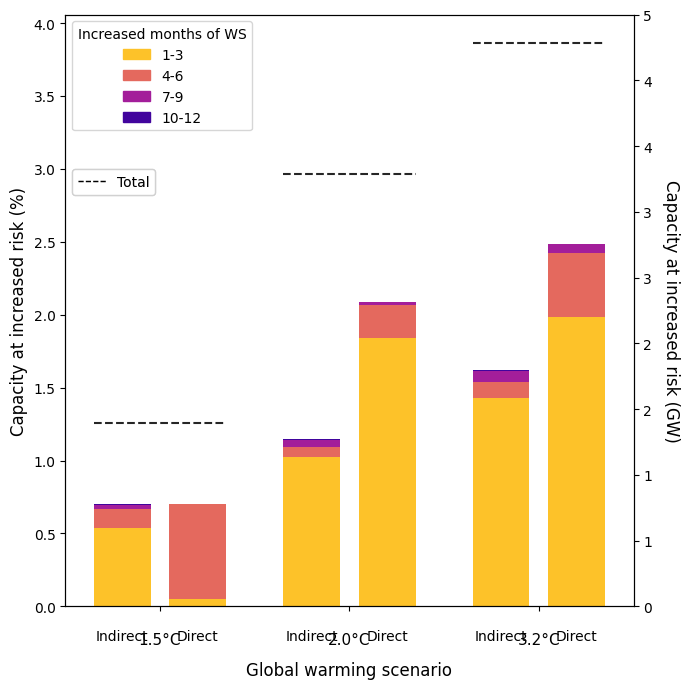

In [74]:
# Plot the percent of data center capacity at increased risk of water scarcity
# Define future scenarios for plotting
future_scenarios_for_plotting = ["1.5°C", "2.0°C", "3.2°C"]

# Define bins for months
bins = [(1, 3), (4, 6), (7, 9), (10, 12)]
bin_labels = ["1-3", "4-6", "7-9", "10-12"]
num_bins = len(bins)

# Define colors (same for both Direct and Indirect)
colors = plt.cm.plasma_r(np.linspace(0.13, 0.9, num_bins))

# Create figure
fig, ax1 = plt.subplots(figsize=(7, 7))

# Define x positions for the bars
x = np.arange(len(future_scenarios_for_plotting))

# Define bar width
bar_width = 0.3

# Define a gap between bars
gap = 0.1  # Adjust for spacing between bars

# Adjust x positions for direct and indirect bars
x_direct = x + (bar_width / 2 + gap / 2)
x_indirect = x - (bar_width / 2 + gap / 2)

# Initialize bottom values for stacking
bottom_direct = np.zeros(len(future_scenarios_for_plotting))
bottom_indirect = np.zeros(len(future_scenarios_for_plotting))

# Plot Indirect bars with stacking (dashed edges)
for i, (start, end) in enumerate(bins):
    bin_data_indirect = vulnerability_counts_indirect.iloc[:, start : end + 1].sum(axis=1)
    ax1.bar(
        x_indirect,
        bin_data_indirect,
        bottom=bottom_indirect,
        width=bar_width,
        color=colors[i],
        label=bin_labels[i] if i == 0 else "",
    )
    bottom_indirect += bin_data_indirect

# Plot Direct bars with stacking
for i, (start, end) in enumerate(bins):
    bin_data_direct = vulnerability_counts_direct.iloc[:, start : end + 1].sum(axis=1)
    ax1.bar(x_direct, bin_data_direct, bottom=bottom_direct, width=bar_width, color=colors[i])
    bottom_direct += bin_data_direct

# Plot Total capacity at risk, as a horizontal line for each scenario
for i, scenario in enumerate(future_scenarios_for_plotting):
    total_capacity = vulnerability_total_capacity_at_risk.loc[
        vulnerability_total_capacity_at_risk["Scenario"] == scenario, "Total_capacity_at_risk"
    ].to_numpy()[0]
    ax1.hlines(
        total_capacity,
        x_indirect[i] - bar_width / 2,
        x_direct[i] + bar_width / 2,
        color="black",
        linestyle="--",
        linewidth=1.5,
        alpha=0.85,
    )
    # Print the total capacity at risk
    print(f"Total capacity at risk for {scenario}: {total_capacity:.1f} %")

# Labels and formatting
ax1.set_ylabel("Capacity at increased risk (%)", fontsize=12)
ax1.set_xlabel("Global warming scenario", fontsize=12, labelpad=10)
ax1.set_xticks(x)
ax1.set_xticklabels(future_scenarios_for_plotting, rotation=0, fontsize=11)
ax1.tick_params(axis="x", labelrotation=0, pad=15)

# Add labels for Direct and Indirect above x-axis tick labels
for i in range(len(future_scenarios_for_plotting)):
    ax1.text(x_direct[i], -0.2, "Direct", ha="center", va="center", fontsize=10, color="black")
    ax1.text(x_indirect[i], -0.2, "Indirect", ha="center", va="center", fontsize=10, color="black")

# Adjust x-axis limits to ensure all bars are in view
ax1.set_xlim(-0.5, len(future_scenarios_for_plotting) - 0.5)

# Add legend for the bins
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(len(bins))]
legend1 = ax1.legend(handles, bin_labels, title="Increased months of WS", loc="upper left", fontsize=10)
ax1.add_artist(legend1)

# Add red line to the legend
total_handle = plt.Line2D([0], [0], color="black", linestyle="--", linewidth=1, label="Total")
legend3 = ax1.legend(handles=[total_handle], loc="upper left", fontsize=10, bbox_to_anchor=(0, 0.75))
ax1.add_artist(legend3)

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Capacity at increased risk (GW)", fontsize=12, rotation=270, labelpad=20)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels([f"{ytick * total_tcp_gw / 100:.0f}" for ytick in ax1.get_yticks()])

# Save the plot
plt.savefig(FIGURES_DIR / "data_center_capacity_increased_wvi_risk_barchart.png", bbox_inches="tight", dpi=300)

# Layout adjustments
plt.tight_layout()
plt.show()

## Exacerbation water scarcity risk figures


Mapping the areas with the greatest increases in water scarcity risk due to data center water use


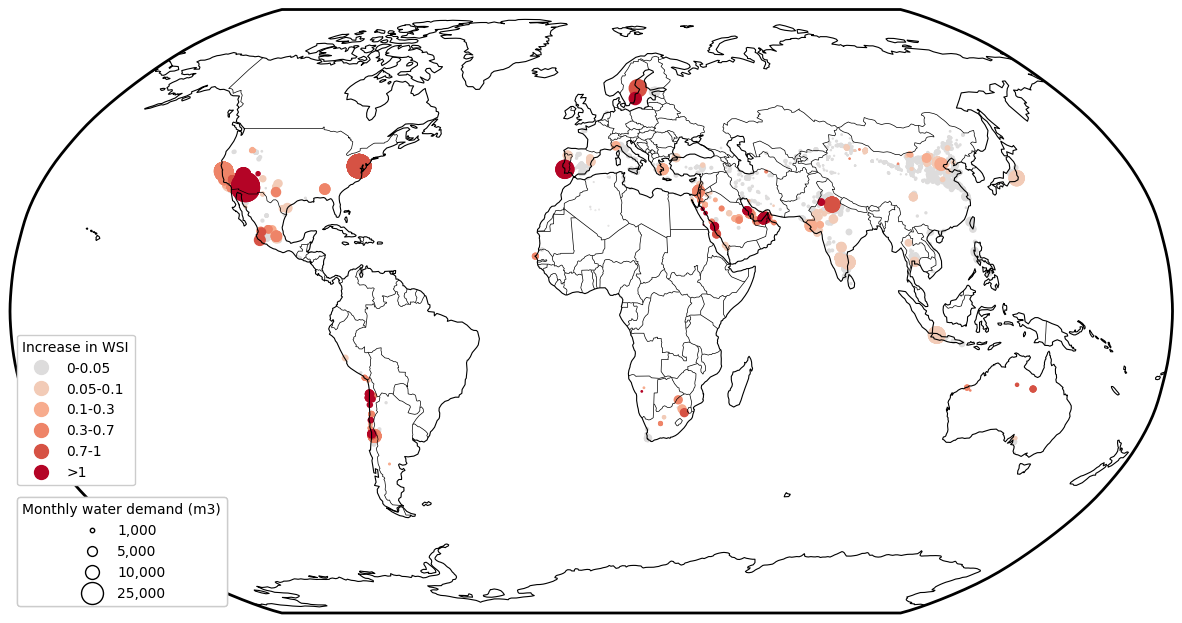

In [12]:
# Plot the relative index for the historical scenario
plot_relative_increase_ws_map(water_scarcity_summary["hist"], FIGURES_DIR, "hist")

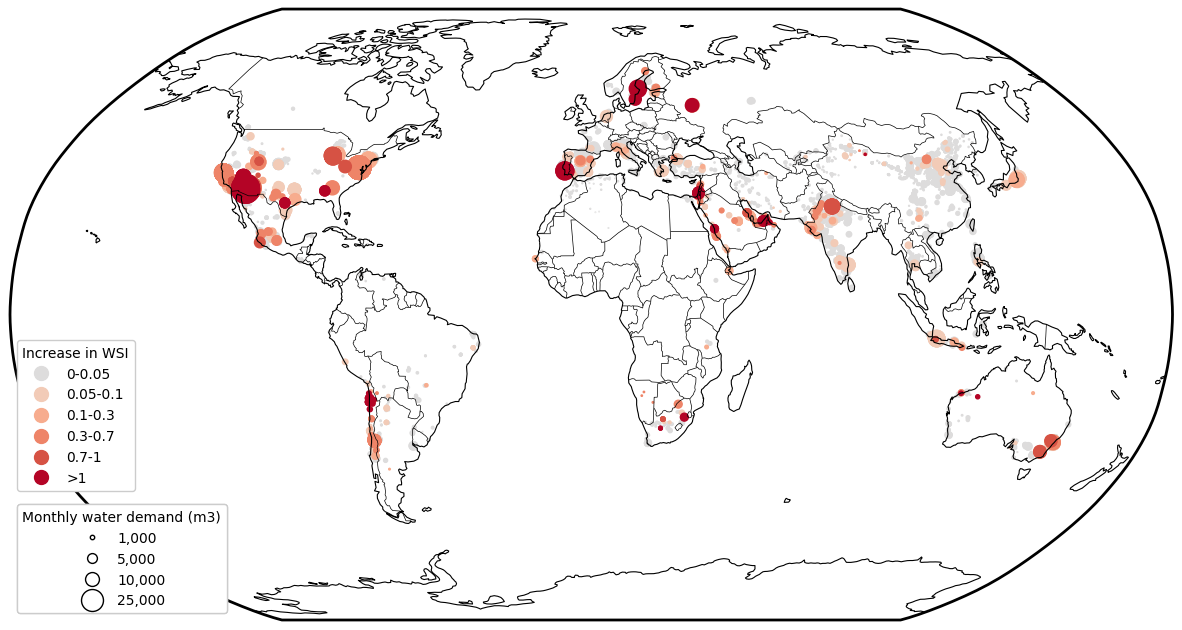

In [13]:
# Plot the relative index for the 1.5°C scenario
plot_relative_increase_ws_map(water_scarcity_summary["1_5C"], FIGURES_DIR, "1_5C")

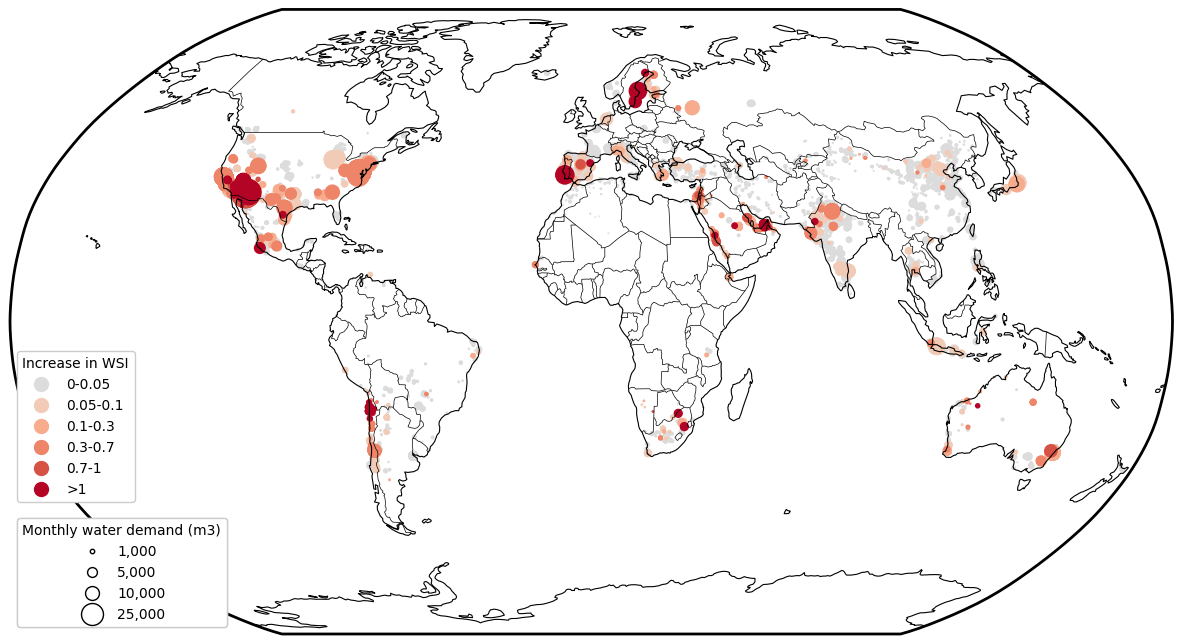

In [14]:
# Plot the relative index for the 2.0°C scenario
plot_relative_increase_ws_map(water_scarcity_summary["2_0C"], FIGURES_DIR, "2_0C")

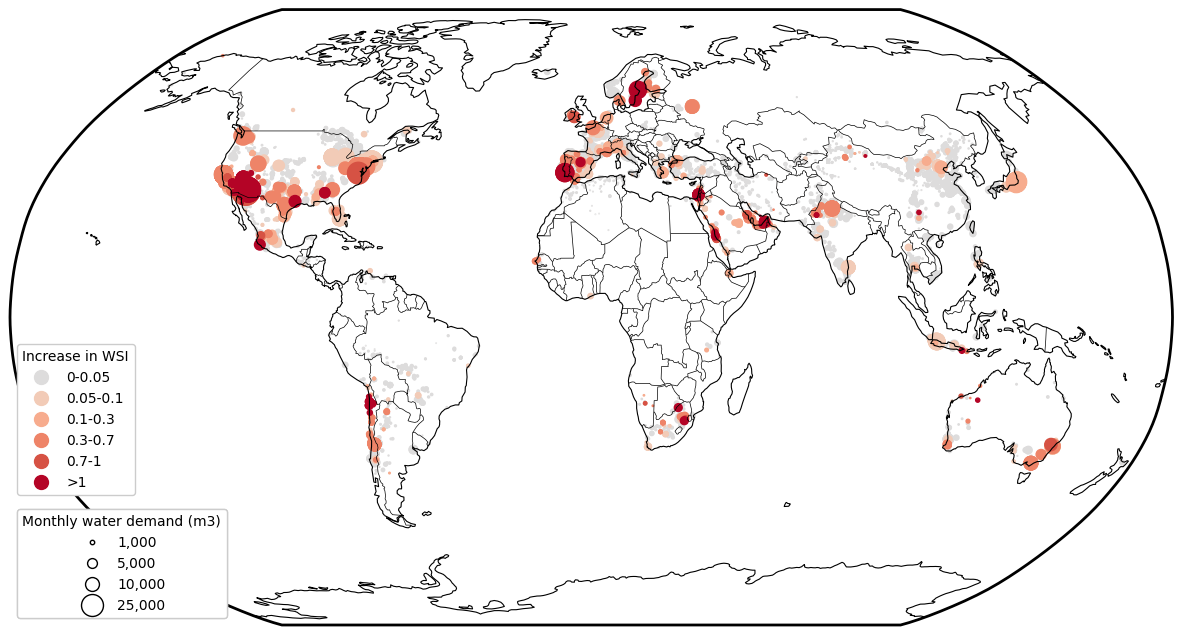

In [15]:
# Plot the relative index for the 3.2°C scenario
plot_relative_increase_ws_map(water_scarcity_summary["3_2C"], FIGURES_DIR, "3_2C")

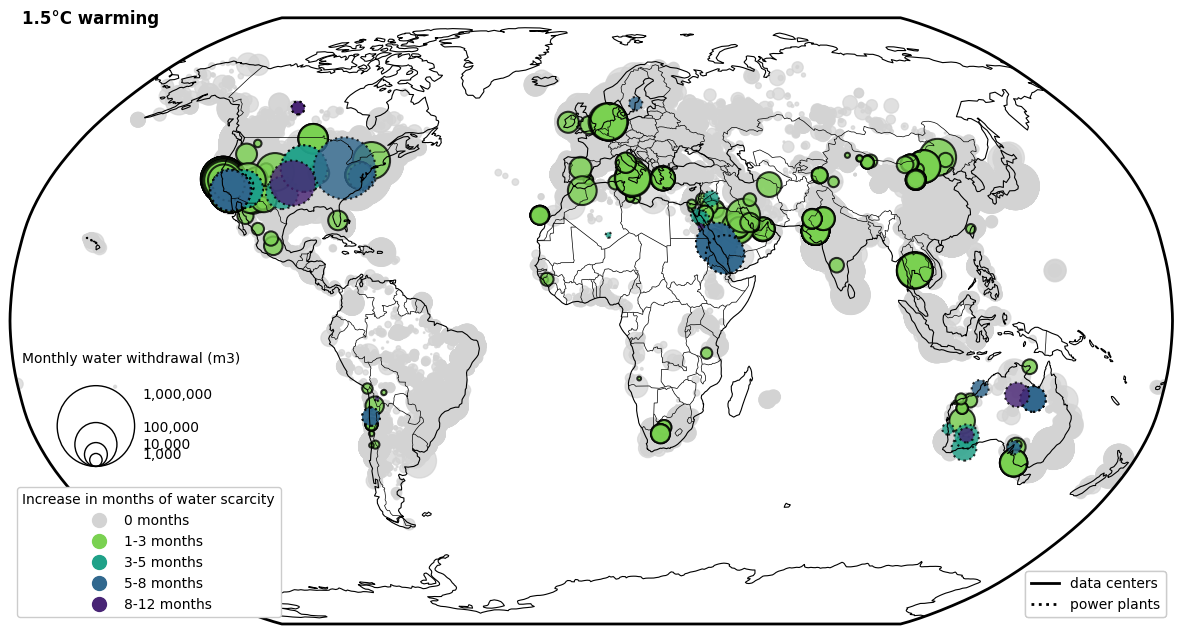

In [10]:
# for 1_5C scenario
plot_months_ws_at_extraction_sites(
    water_scarcity_summary["1_5C"],
    FIGURES_DIR,
    "1_5C",
    "dc_direct_increase_months_count",
    include_dc_contributions=True
)

In [ ]:
a

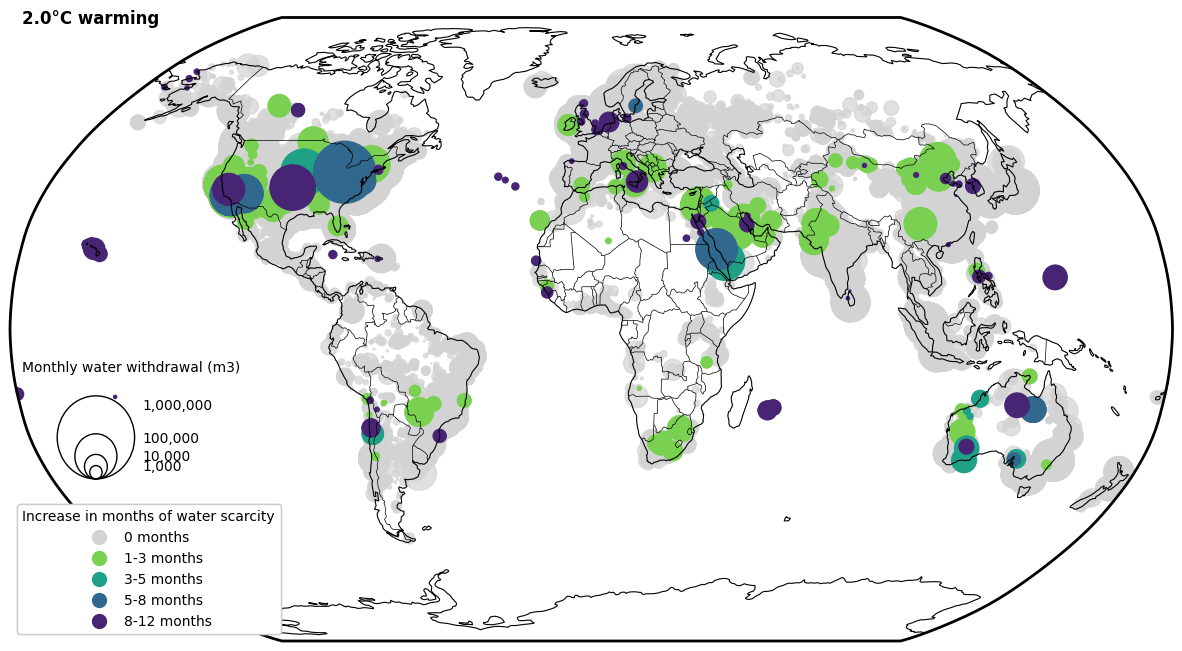

In [33]:
# for 2_0C scenario
plot_months_ws_at_extraction_sites(
    water_scarcity_summary["2_0C"],
    FIGURES_DIR,
    "2_0C",
    "dc_direct_increase_months_count",
    include_dc_contributions=True
)